In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture
!pip install matplotlib statsmodels pandas scikit-learn tensorflow openpyxl pmdarima

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AutoReg as pm

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

plt.style.use("fivethirtyeight")

# Parametreler
start_date = "2018-01-01"
end_date = "2018-12-31"

# Tahmin periyotları - 3 farklı senaryo
TAHMIN_PERIYOTLARI = {
    '1_gun': 1,    # 03 Aralik 2018 (1 is gunu)
    '10_gun': 10,  # 03-14 Aralik 2018 (10 is gunu = 2 hafta)
    '21_gun': 21   # 03-31 Aralik 2018 (21 is gunu = 1 ay)
}

# Aktif periyot seçimi - değiştirmek için '1_gun', '10_gun' veya '21_gun' yazın
AKTIF_PERIYOT = '21_gun'
tahminEdilecekGunSayisi = TAHMIN_PERIYOTLARI[AKTIF_PERIYOT]
time_step = 30

# CSV dosyası yolu
DATA_FILE = "/content/drive/MyDrive/Colab Notebooks/tez/Data/BIST_50_2018_Data.csv"


In [5]:
# CSV'den veri okuma
print(f" Veri yükleniyor: {DATA_FILE}")

df_raw = pd.read_csv(DATA_FILE)

# Veri temizleme
df = df_raw.copy()

# Sütun adını düzelt (Now -> Close)
df = df.rename(columns={'Now': 'Close'})

# Tarih formatını düzelt (31.12.2018 -> 2018-12-31)
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')

# Sayı formatlarını düzelt (Türkçe format: virgül -> nokta)
numeric_cols = ['Close', 'Open', 'High', 'Low']
for col in numeric_cols:
    if df[col].dtype == 'object':
        df[col] = df[col].str.replace('.', '', regex=False) # Binlik ayracı kaldır
        df[col] = df[col].str.replace(',', '.', regex=False) # Virgülü noktaya çevir
        df[col] = df[col].astype(float)

# Sıralamayı düzelt (eskiden yeniye)
df = df.sort_values('Date').reset_index(drop=True)

# Index olarak tarih ata
df = df.set_index('Date')

# Tarih filtreleme
df = df[(df.index >= start_date) & (df.index <= end_date)]

print(f" Toplam veri: {len(df)} iş günü")
print(f" Tarih aralığı: {df.index[0].strftime('%Y-%m-%d')} → {df.index[-1].strftime('%Y-%m-%d')}")

 Veri yükleniyor: /content/drive/MyDrive/Colab Notebooks/tez/Data/BIST_50_2018_Data.csv
 Toplam veri: 250 iş günü
 Tarih aralığı: 2018-01-02 → 2018-12-31


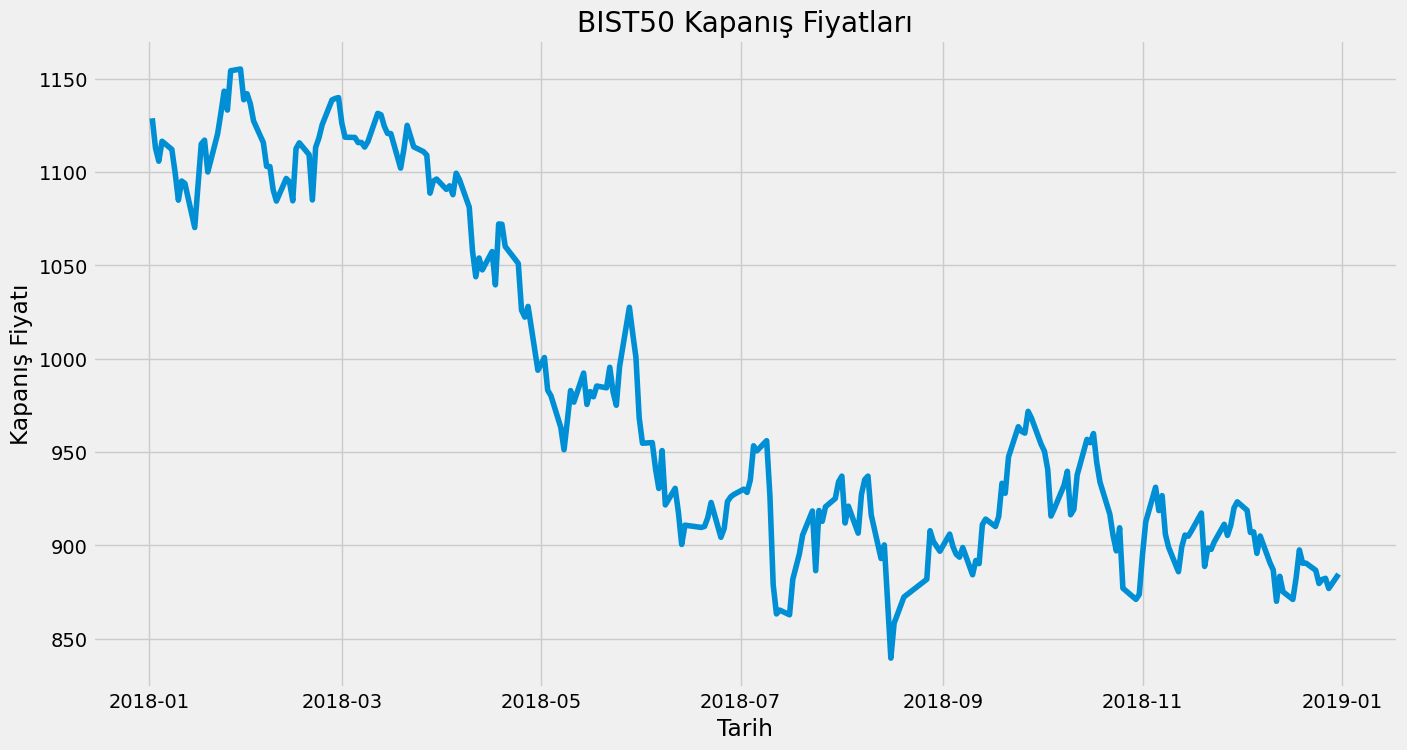

In [6]:
# Grafiği çizme
plt.figure(figsize=(15, 8))
plt.plot(df['Close'], label="Kapanış")
plt.title("BIST50 Kapanış Fiyatları")
plt.xlabel("Tarih")
plt.ylabel("Kapanış Fiyatı")
plt.show()

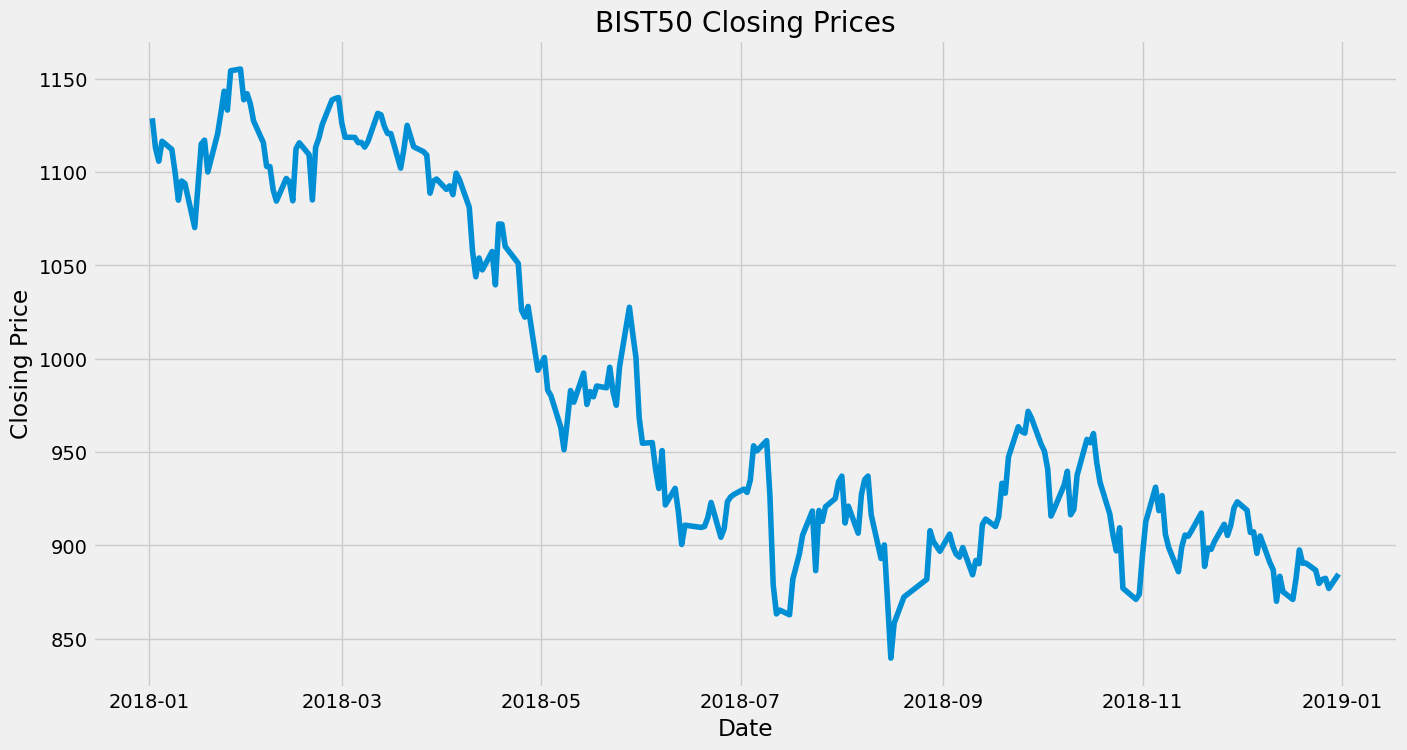

In [7]:
# Grafiği çizme (İngilizce)
plt.figure(figsize=(15, 8))
plt.plot(df['Close'], label="Closing")
plt.title("BIST50 Closing Prices")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.show()

In [8]:
print(df.head().to_string())

              Close     Open     High      Low   Volume  Diff %
Date                                                           
2018-01-02  1128.88  1110.80  1130.61  1110.05  856,59M   1,99%
2018-01-03  1112.95  1130.94  1137.27  1110.44    1,02B  -1,41%
2018-01-04  1105.85  1113.22  1124.65  1102.61    1,02B  -0,64%
2018-01-05  1116.55  1112.34  1122.29  1109.74  794,28M   0,97%
2018-01-08  1112.16  1125.10  1127.52  1111.59  806,07M  -0,39%


In [9]:
df.tail()

Close    Open    High     Low   Volume  Diff %
Date                                                       
2018-12-25  879.59  881.22  883.64  876.50  287,94M  -0,80%
2018-12-26  881.76  882.54  885.29  878.30  241,79M   0,25%
2018-12-27  882.36  889.70  890.90  879.68  475,36M   0,07%
2018-12-28  876.93  884.41  887.68  873.77  453,98M  -0,62%
2018-12-31  884.65  879.48  885.38  875.27  333,20M   0,88%

## Önnişleme

In [10]:
# Sadece 'Close' sütununu al
df_Close = df[['Close']]
df_Close

Close
Date               
2018-01-02  1128.88
2018-01-03  1112.95
2018-01-04  1105.85
2018-01-05  1116.55
2018-01-08  1112.16
...             ...
2018-12-25   879.59
2018-12-26   881.76
2018-12-27   882.36
2018-12-28   876.93
2018-12-31   884.65

[250 rows x 1 columns]

In [11]:
# CSV'den gelen veri zaten sadece iş günlerini içeriyor
# Hafta sonları dahil etmiyoruz (imputation gereksiz)
full_df = df_Close.copy()

# Sonuçları yazdır
print(f"Toplam iş günü: {len(full_df)}")
print(full_df)

Toplam iş günü: 250
              Close
Date               
2018-01-02  1128.88
2018-01-03  1112.95
2018-01-04  1105.85
2018-01-05  1116.55
2018-01-08  1112.16
...             ...
2018-12-25   879.59
2018-12-26   881.76
2018-12-27   882.36
2018-12-28   876.93
2018-12-31   884.65

[250 rows x 1 columns]


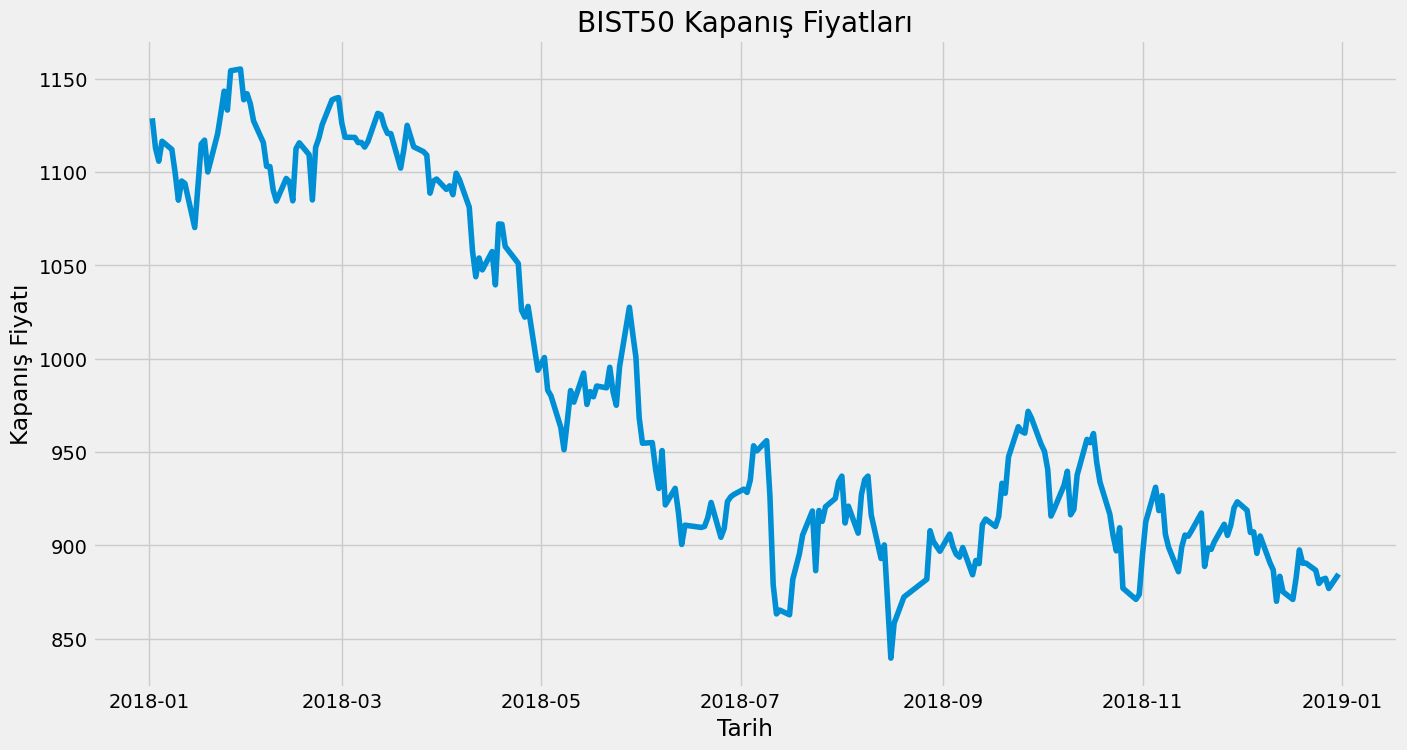

In [12]:
# Grafiği çizme
plt.figure(figsize=(15, 8))
plt.plot(full_df, label="Kapanış")
plt.title("BIST50 Kapanış Fiyatları")
plt.xlabel("Tarih")
plt.ylabel("Kapanış Fiyatı")
plt.show()

In [13]:
from sklearn.preprocessing import MinMaxScaler

# Min-Max normalizasyonu için scaler oluştur
scaler = MinMaxScaler()

# 'Close' sütununu numpy dizisine dönüştür ve reshape et
close_values = full_df['Close'].values.reshape(-1, 1)

# NaN değerleri içermeyen değerleri normalleştir
# Bu adımda, NaN değerleri olan satırlar işleme dahil edilmeyecek
normalized_values = scaler.fit_transform(close_values)

# Normalleştirilmiş değerleri 'Close_Normalized' olarak full_df'e ekle
full_df['Close_Normalized'] = normalized_values

full_df = pd.DataFrame(full_df)

# Sonucu kontrol et
full_df

Close  Close_Normalized
Date                                 
2018-01-02  1128.88          0.916487
2018-01-03  1112.95          0.866018
2018-01-04  1105.85          0.843524
2018-01-05  1116.55          0.877424
2018-01-08  1112.16          0.863515
...             ...               ...
2018-12-25   879.59          0.126695
2018-12-26   881.76          0.133570
2018-12-27   882.36          0.135471
2018-12-28   876.93          0.118268
2018-12-31   884.65          0.142726

[250 rows x 2 columns]

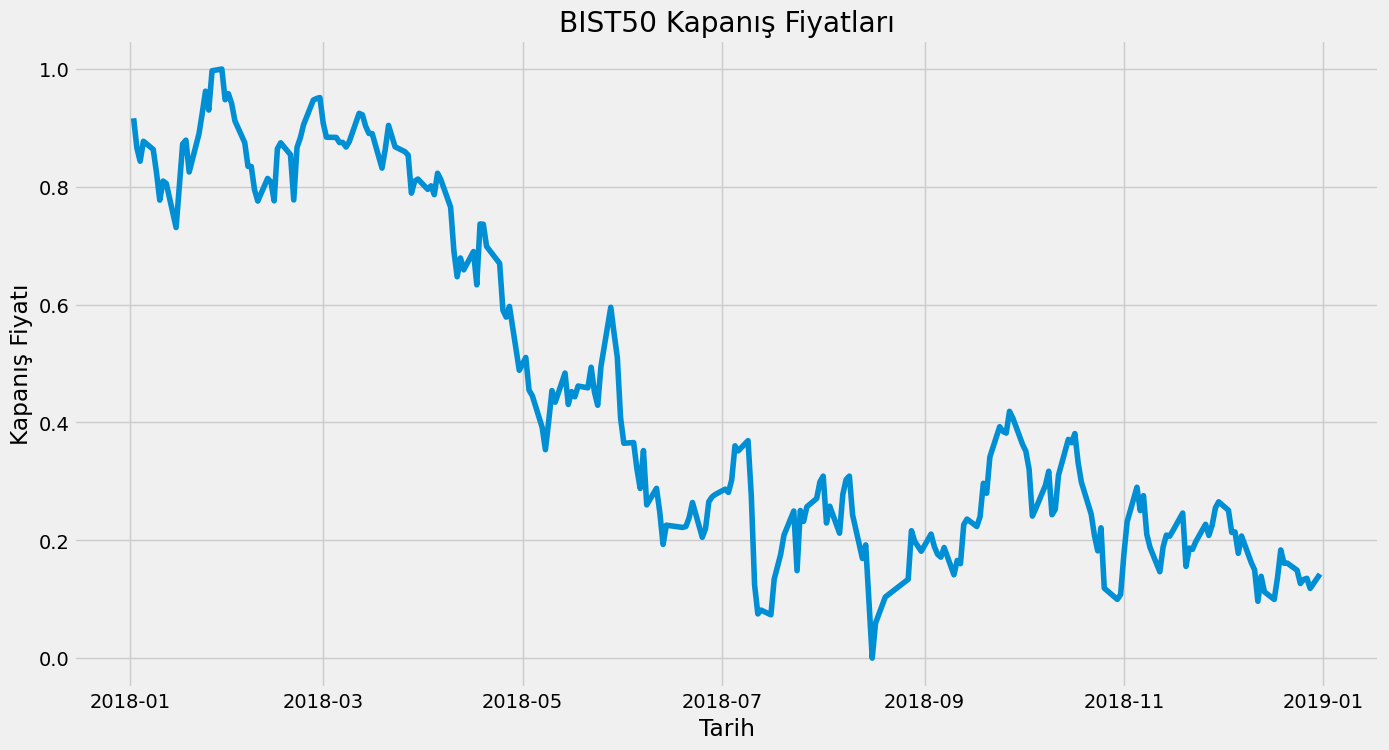

In [14]:
# Normalize Edilmiş Grafiği çizme
plt.figure(figsize=(15, 8))
plt.plot(full_df['Close_Normalized'], label="Kapanış")
plt.title("BIST50 Kapanış Fiyatları")
plt.xlabel("Tarih")
plt.ylabel("Kapanış Fiyatı")
plt.show()

In [15]:
def create_test_train_data(df, column_name, num_non_nan):
    """
    Verilen DataFrame'den, belirtilen sütunda NaN olmayan belirli sayıda son değeri içeren
    test veri seti oluşturur ve geriye kalan verileri eğitim seti olarak döndürür.

    Args:
    df : pandas.DataFrame
    İşlem yapılacak DataFrame.
    column_name : str
    İşlemlerin uygulanacağı sütun adı.
    num_non_nan : int
    Seçilecek NaN olmayan değer sayısı.

    Returns:
    pandas.DataFrame, pandas.DataFrame
    Test veri seti, Eğitim veri seti.
    """
    # 'column_name' sütunundaki NaN olmayan değerlerin indekslerini al
    non_nan_indices = df[column_name].dropna().index

    # Son 'num_non_nan' kadar NaN olmayan değerin indeksi
    last_valid_indices = non_nan_indices[-num_non_nan:]

    # Seçilen son geçerli indeksin başlangıcını bul
    start_index = last_valid_indices[0]

    # start_index'in DataFrame içindeki konumunu bul
    start_pos = df.index.get_loc(start_index)

    # Test verisi olarak seçilecek başlangıç noktası
    test_start_index = df.index[start_pos]

    # Başlangıç indeksinden itibaren tüm verileri test verisi olarak seç
    test_data = df.loc[test_start_index:, column_name]

    # Test verisinin başlangıç indeksi öncesinde kalan verileri eğitim verisi olarak seç
    train_data = df.loc[:df.index[start_pos - 1], column_name] if start_pos > 0 else pd.DataFrame()

    return pd.DataFrame(test_data), pd.DataFrame(train_data)

# Fonksiyonu test et
test_data, train_data = create_test_train_data(full_df, 'Close_Normalized', tahminEdilecekGunSayisi)

test_data

Close_Normalized
Date                        
2018-12-03          0.250950
2018-12-04          0.213313
2018-12-05          0.214326
2018-12-06          0.177829
2018-12-07          0.207325
2018-12-10          0.161862
2018-12-11          0.149728
2018-12-12          0.096471
2018-12-13          0.138956
2018-12-14          0.112597
2018-12-17          0.099607
2018-12-18          0.136199
2018-12-19          0.183659
2018-12-20          0.161101
2018-12-21          0.161228
2018-12-24          0.149189
2018-12-25          0.126695
2018-12-26          0.133570
2018-12-27          0.135471
2018-12-28          0.118268
2018-12-31          0.142726

In [16]:
train_data

Close_Normalized
Date                        
2018-01-02          0.916487
2018-01-03          0.866018
2018-01-04          0.843524
2018-01-05          0.877424
2018-01-08          0.863515
...                      ...
2018-11-26          0.227221
2018-11-27          0.208307
2018-11-28          0.225352
2018-11-29          0.255006
2018-11-30          0.265334

[229 rows x 1 columns]

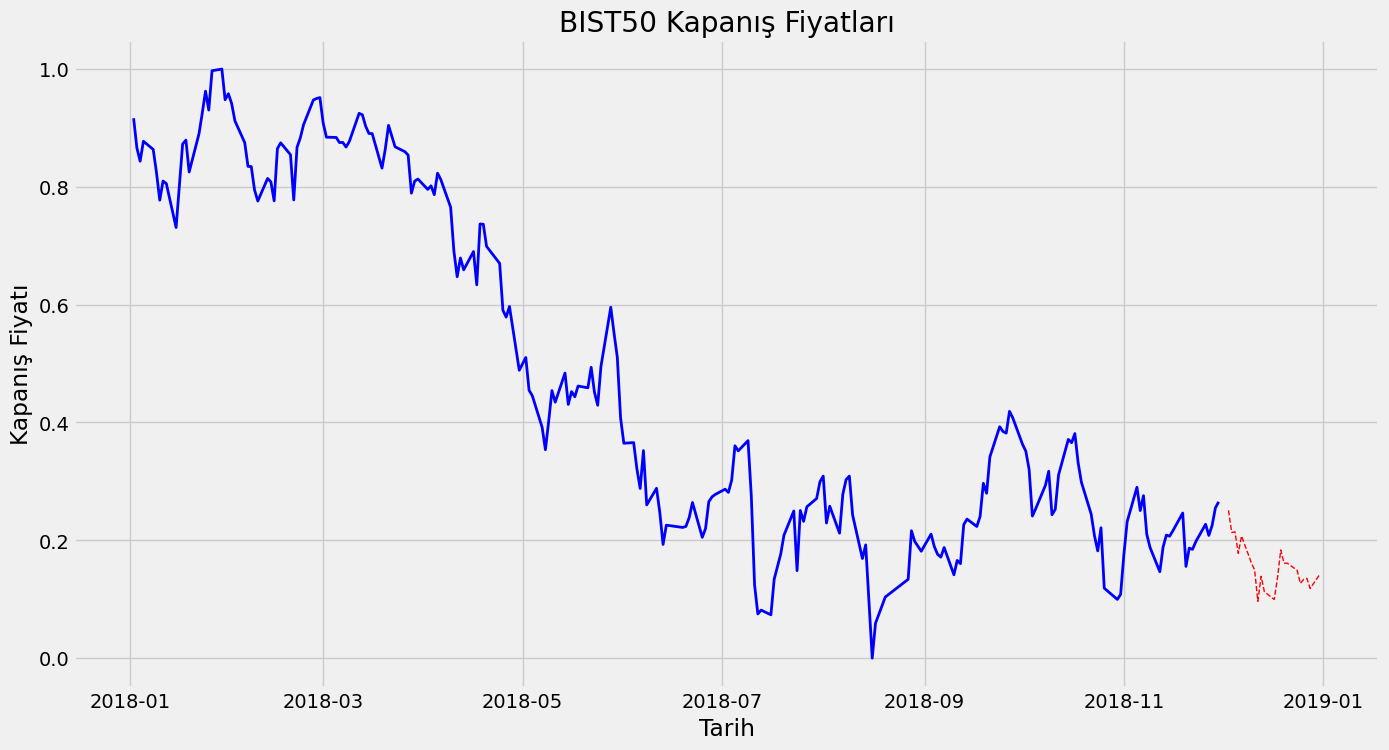

In [17]:
# Grafiği çizme
plt.figure(figsize=(15, 8))

# Orijinal Kapanış Fiyatlarını Çizme (NaN değerlerle)
plt.plot(train_data['Close_Normalized'], label="Eğitim için Ayrılan Gerçek Kapanış (NaN ile)", color='blue', linestyle='-', linewidth=2)

# İmpütasyonla Doldurulmuş Değerleri Çizme
plt.plot(test_data['Close_Normalized'], label="Test için Ayrılan Gerçek Kapanış (NaN ile)", color='red', linestyle='--', linewidth=1)


plt.title("BIST50 Kapanış Fiyatları")
plt.xlabel("Tarih")
plt.ylabel("Kapanış Fiyatı")
plt.show()

In [18]:
# array'i dataset'e çevir
def create_dataset_with_dates(dataset, column_name, time_step=1):
    dataX, dataY, datesX, datesY = [], [], [], []
    for i in range(len(dataset) - time_step):
        a = dataset[column_name].iloc[i:(i + time_step)].values
        dataX.append(a)
        dataY.append(dataset[column_name].iloc[i + time_step])
        datesX.append(dataset.index[i:(i + time_step)]) # X için tarihleri sakla
        datesY.append(dataset.index[i + time_step]) # Y için tarihleri sakla
    return np.array(dataX), np.array(dataY), np.array(datesX), np.array(datesY)

In [19]:
# Fonksiyonu kullanarak veri seti oluşturun
X_train, y_train, datesX_train, datesY_train = create_dataset_with_dates(train_data, 'Close_Normalized', time_step)


# Elde edilen verileri göster

X_train= pd.DataFrame(X_train)
y_train= pd.DataFrame(y_train)
datesX_train= pd.DataFrame(datesX_train)
datesY_train= pd.DataFrame(datesY_train)

In [20]:
# X ve y DataFrame'lerini birleştir
combined_train_dates = pd.concat([datesX_train, datesY_train], axis=1)

# Kolon isimlerini güncelle
combined_train_dates.columns = [f'feature_{i}' for i in range(datesX_train.shape[1])] + ['target']

# Birleştirilmiş DataFrame'i göster
combined_train_dates

feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   2018-01-02 2018-01-03 2018-01-04 2018-01-05 2018-01-08 2018-01-09   
1   2018-01-03 2018-01-04 2018-01-05 2018-01-08 2018-01-09 2018-01-10   
2   2018-01-04 2018-01-05 2018-01-08 2018-01-09 2018-01-10 2018-01-11   
3   2018-01-05 2018-01-08 2018-01-09 2018-01-10 2018-01-11 2018-01-12   
4   2018-01-08 2018-01-09 2018-01-10 2018-01-11 2018-01-12 2018-01-15   
..         ...        ...        ...        ...        ...        ...   
194 2018-10-12 2018-10-15 2018-10-16 2018-10-17 2018-10-18 2018-10-19   
195 2018-10-15 2018-10-16 2018-10-17 2018-10-18 2018-10-19 2018-10-22   
196 2018-10-16 2018-10-17 2018-10-18 2018-10-19 2018-10-22 2018-10-23   
197 2018-10-17 2018-10-18 2018-10-19 2018-10-22 2018-10-23 2018-10-24   
198 2018-10-18 2018-10-19 2018-10-22 2018-10-23 2018-10-24 2018-10-25   

     feature_6  feature_7  feature_8  feature_9  ... feature_21 feature_22  \
0   2018-01-10 2018-01-11 2018-01-12 2018-01-15  ... 2018-01-31 2018-02-01   
1   2018-01-11 2018-01-12 2018-01-15 2018-01-16  ... 2018-02-01 2018-02-02   
2   2018-01-12 2018-01-15 2018-01-16 2018-01-17  ... 2018-02-02 2018-02-05   
3   2018-01-15 2018-01-16 2018-01-17 2018-01-18  ... 2018-02-05 2018-02-06   
4   2018-01-16 2018-01-17 2018-01-18 2018-01-19  ... 2018-02-06 2018-02-07   
..         ...        ...        ...        ...  ...        ...        ...   
194 2018-10-22 2018-10-23 2018-10-24 2018-10-25  ... 2018-11-13 2018-11-14   
195 2018-10-23 2018-10-24 2018-10-25 2018-10-26  ... 2018-11-14 2018-11-15   
196 2018-10-24 2018-10-25 2018-10-26 2018-10-30  ... 2018-11-15 2018-11-16   
197 2018-10-25 2018-10-26 2018-10-30 2018-10-31  ... 2018-11-16 2018-11-19   
198 2018-10-26 2018-10-30 2018-10-31 2018-11-01  ... 2018-11-19 2018-11-20   

    feature_23 feature_24 feature_25 feature_26 feature_27 feature_28  \
0   2018-02-02 2018-02-05 2018-02-06 2018-02-07 2018-02-08 2018-02-09   
1   2018-02-05 2018-02-06 2018-02-07 2018-02-08 2018-02-09 2018-02-12   
2   2018-02-06 2018-02-07 2018-02-08 2018-02-09 2018-02-12 2018-02-13   
3   2018-02-07 2018-02-08 2018-02-09 2018-02-12 2018-02-13 2018-02-14   
4   2018-02-08 2018-02-09 2018-02-12 2018-02-13 2018-02-14 2018-02-15   
..         ...        ...        ...        ...        ...        ...   
194 2018-11-15 2018-11-16 2018-11-19 2018-11-20 2018-11-21 2018-11-22   
195 2018-11-16 2018-11-19 2018-11-20 2018-11-21 2018-11-22 2018-11-23   
196 2018-11-19 2018-11-20 2018-11-21 2018-11-22 2018-11-23 2018-11-26   
197 2018-11-20 2018-11-21 2018-11-22 2018-11-23 2018-11-26 2018-11-27   
198 2018-11-21 2018-11-22 2018-11-23 2018-11-26 2018-11-27 2018-11-28   

    feature_29     target  
0   2018-02-12 2018-02-13  
1   2018-02-13 2018-02-14  
2   2018-02-14 2018-02-15  
3   2018-02-15 2018-02-16  
4   2018-02-16 2018-02-19  
..         ...        ...  
194 2018-11-23 2018-11-26  
195 2018-11-26 2018-11-27  
196 2018-11-27 2018-11-28  
197 2018-11-28 2018-11-29  
198 2018-11-29 2018-11-30  

[199 rows x 31 columns]

In [21]:
# X ve y DataFrame'lerini birleştir
combined_train = pd.concat([X_train, y_train], axis=1)

# Kolon isimlerini güncelle
combined_train.columns = [f'feature_{i}' for i in range(X_train.shape[1])] + ['target']

# Birleştirilmiş DataFrame'i göster
combined_train

feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0     0.916487   0.866018   0.843524   0.877424   0.863515   0.824230   
1     0.866018   0.843524   0.877424   0.863515   0.824230   0.777373   
2     0.843524   0.877424   0.863515   0.824230   0.777373   0.809878   
3     0.877424   0.863515   0.824230   0.777373   0.809878   0.805696   
4     0.863515   0.824230   0.777373   0.809878   0.805696   0.730959   
..         ...        ...        ...        ...        ...        ...   
194   0.310734   0.371277   0.365670   0.381225   0.331707   0.298631   
195   0.371277   0.365670   0.381225   0.331707   0.298631   0.244329   
196   0.365670   0.381225   0.331707   0.298631   0.244329   0.207800   
197   0.381225   0.331707   0.298631   0.244329   0.207800   0.182043   
198   0.331707   0.298631   0.244329   0.207800   0.182043   0.221265   

     feature_6  feature_7  feature_8  feature_9  ...  feature_21  feature_22  \
0     0.777373   0.809878   0.805696   0.730959  ...    0.958180    0.941389   
1     0.809878   0.805696   0.730959   0.801483  ...    0.941389    0.912052   
2     0.805696   0.730959   0.801483   0.872735  ...    0.912052    0.875048   
3     0.730959   0.801483   0.872735   0.879325  ...    0.875048    0.834748   
4     0.801483   0.872735   0.879325   0.825212  ...    0.834748    0.834495   
..         ...        ...        ...        ...  ...         ...         ...   
194   0.244329   0.207800   0.182043   0.221265  ...    0.188601    0.208877   
195   0.207800   0.182043   0.221265   0.118711  ...    0.208877    0.206976   
196   0.182043   0.221265   0.118711   0.099702  ...    0.206976    0.216259   
197   0.221265   0.118711   0.099702   0.108130  ...    0.216259    0.246293   
198   0.118711   0.099702   0.108130   0.175802  ...    0.246293    0.155652   

     feature_23  feature_24  feature_25  feature_26  feature_27  feature_28  \
0      0.912052    0.875048    0.834748    0.834495    0.794861    0.775884   
1      0.875048    0.834748    0.834495    0.794861    0.775884    0.814282   
2      0.834748    0.834495    0.794861    0.775884    0.814282    0.808484   
3      0.834495    0.794861    0.775884    0.814282    0.808484    0.776264   
4      0.794861    0.775884    0.814282    0.808484    0.776264    0.864846   
..          ...         ...         ...         ...         ...         ...   
194    0.206976    0.216259    0.246293    0.155652    0.186827    0.184609   
195    0.216259    0.246293    0.155652    0.186827    0.184609    0.197725   
196    0.246293    0.155652    0.186827    0.184609    0.197725    0.227221   
197    0.155652    0.186827    0.184609    0.197725    0.227221    0.208307   
198    0.186827    0.184609    0.197725    0.227221    0.208307    0.225352   

     feature_29    target  
0      0.814282  0.808484  
1      0.808484  0.776264  
2      0.776264  0.864846  
3      0.864846  0.874762  
4      0.874762  0.854581  
..          ...       ...  
194    0.197725  0.227221  
195    0.227221  0.208307  
196    0.208307  0.225352  
197    0.225352  0.255006  
198    0.255006  0.265334  

[199 rows x 31 columns]

In [22]:
# NaN olmayan satırları bul train_data için
non_nan_rows = ~combined_train.isnull().any(axis=1)


# Hiç NaN içermeyen veri setini ve tarihlerini seç
datasetComplete = combined_train[non_nan_rows]
datasetComplete_dates = combined_train_dates[non_nan_rows]



# En az bir NaN içeren veri setini ve tarihlerini seç
datasetMissing = combined_train[combined_train.isnull().any(axis=1)]
datasetMissing_dates = combined_train_dates[combined_train.isnull().any(axis=1)]

In [23]:
datasetComplete.style.highlight_null('red') # NaN değerleri varsa görelim

In [24]:
datasetMissing.style.highlight_null('red') # NaN değerleri varsa görelim

In [25]:
len(datasetComplete)

199

In [26]:
len(datasetMissing)

0

In [27]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense


# Kullanıcıdan sütun bazlı ve satır bazlı imputasyon yöntemlerinin seçimini alma
print("Satır bazlı eksik veri doldurma için bir regresyon modeli seçin:")
print("1: K-Nearest Neighbors")
print("2: Linear Regression")
print("3: Support Vector Machine")
print("4: Decision Tree")
print("5: Random Forest")
print("6: Gradient Boosting")
print("7: Deep Learning (Keras)")

row_model_choice = input("Seçiminiz (1/2/3/4/5/6/7): ")

print("\nSütun bazlı eksik veri doldurma için bir yöntem seçin:")
print("1: Ortalama")
print("2: Medyan")
print("3: Mod")
print("4: Ardışık Değerlerle Doldurma (Forward/Backward Fill)")
print("5: KNN Imputer")
print("6: Interpolate")
column_method_choice = input("Seçiminiz (1/2/3/4/5/6): ")



# Kullanıcının seçimlerini onayla
row_models = {
    "1": "K-Nearest Neighbors",
    "2": "Linear Regression",
    "3": "Support Vector Machine",
    "4": "Decision Tree",
    "5": "Random Forest",
    "6": "Gradient Boosting",
    "7": "Deep Learning (Keras)",

}

column_methods = {
    "1": "Ortalama",
    "2": "Medyan",
    "3": "Mod",
    "4": "Ardışık Değerlerle Doldurma (Forward-Backward Fill)",
    "5": "KNN Imputer",
    "6": "Interpolate"
}


# Kullanıcının seçtiği model ve yöntemleri yazdır
selected_row_model = row_models.get(row_model_choice, "Bilinmeyen model")
selected_column_method = column_methods.get(column_method_choice, "Bilinmeyen yöntem")








def get_regression_model(choice, input_shape):
    models = {
    "1": KNeighborsRegressor(),
    "2": LinearRegression(),
    "3": SVR(),
    "4": DecisionTreeRegressor(),
    "5": RandomForestRegressor(),
    "6": HistGradientBoostingRegressor(), # Daha önceden eklemiştiniz
    "7": Sequential([
    Dense(64, activation='relu', input_shape=(input_shape,)),
    Dense(32, activation='relu'),
    Dense(1, activation='linear') # MLP için son aktivasyon değiştirdim
    ])
    }
    model = models.get(choice)

    if choice == "7":
        model.compile(optimizer='adam', loss='mean_squared_error')
    return model


Satır bazlı eksik veri doldurma için bir regresyon modeli seçin:
1: K-Nearest Neighbors
2: Linear Regression
3: Support Vector Machine
4: Decision Tree
5: Random Forest
6: Gradient Boosting
7: Deep Learning (Keras)
Seçiminiz (1/2/3/4/5/6/7): 1

Sütun bazlı eksik veri doldurma için bir yöntem seçin:
1: Ortalama
2: Medyan
3: Mod
4: Ardışık Değerlerle Doldurma (Forward/Backward Fill)
5: KNN Imputer
6: Interpolate
Seçiminiz (1/2/3/4/5/6): 1


In [28]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, Input
from sklearn.impute import KNNImputer




# Sütun bazlı eksik veri doldurma fonksiyonu
def apply_column_imputation(dframe, method):
    datasetComplete_copy = datasetComplete.copy()
    dframe_copy = dframe.copy()

    # Ortalama kullanarak doldurma
    if method == "1":
        mean_value = dframe.mean(axis=1)
        dframe.fillna(mean_value.item(), inplace=True)

    # Medyan kullanarak doldurma
    elif method == "2":
        median_value = dframe.median(axis=1)
        dframe.fillna(median_value.item(), inplace=True)

    # Mod (en sık değer) kullanarak doldurma
    elif method == "3":
        for column in dframe.columns:
            mode_values = dframe[column].mode()
            if not mode_values.empty:
                dframe[column].fillna(mode_values.iloc[0], inplace=True)
            else:
                median_value = dframe[column].median()
                dframe[column].fillna(median_value, inplace=True)

    # Ardışık değerlerle doldurma (ileri veya geri)
    elif method == "4":
        dframe.fillna(method='ffill', axis=1, inplace=True)
        dframe.fillna(method='bfill', axis=1, inplace=True)

    # KNN Imputer kullanarak doldurma
    elif method == "5":
        combined_data = pd.concat([datasetComplete, dframe], ignore_index=True)
        imputer = KNNImputer(n_neighbors=3)
        imputed_data = imputer.fit_transform(combined_data)
        imputed_df = pd.DataFrame(imputed_data, columns=combined_data.columns)
        updated_dframe = imputed_df.iloc[-1:]
        return updated_dframe

    # Interpolate (İnterpolasyon)
    elif method == "6":
        dframe.interpolate(axis=1, inplace=True)

    # Eksik veri yok
    elif method == "7":
        pass

    return dframe




# Satır bazlı model seçim fonksiyonu
def get_regression_model(choice, input_shape):
    models = {
        '1': KNeighborsRegressor(),
        '2': LinearRegression(),
        '3': SVR(),
        '4': DecisionTreeRegressor(),
        '5': RandomForestRegressor(),
        '6': HistGradientBoostingRegressor()
    }
    model = models.get(choice)
    if choice == '7':
        model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model




def find_max_nan_column_sum(df, satir_indeksi):
    sutun_isimleri = []
    for sutun_adi in df.columns:
        if np.isnan(df.loc[satir_indeksi, sutun_adi]):
            sutun_isimleri.append(sutun_adi)

    if not sutun_isimleri:
        return None

    column_nan_sums = df[sutun_isimleri].isnull().sum()
    column_nan_sums.sort_values(ascending=False, inplace=True)
    en_fazla_nan_sutun = column_nan_sums.index[0]
    sutun_indeksi = df.columns.get_loc(en_fazla_nan_sutun)
    return sutun_indeksi


In [29]:
def update_with_predictions(datasetMissing, datasetMissing_dates, predicted_value, target_date):
    matched_indices = np.where(datasetMissing_dates == target_date)
    for row_pos, col_pos in zip(matched_indices[0], matched_indices[1]):
        row_label = datasetMissing_dates.index[row_pos]
        col_name = datasetMissing_dates.columns[col_pos]
        datasetMissing.at[row_label, col_name] = predicted_value
    return datasetMissing


def remove_filled_rows(datasetMissing, datasetMissing_dates, datasetComplete, datasetComplete_dates):
    completed_rows_indexes = datasetMissing[~datasetMissing.isnull().any(axis=1)].index
    for index in completed_rows_indexes:
        datasetComplete = pd.concat([datasetComplete, datasetMissing.loc[[index]]])
        datasetComplete_dates = pd.concat([datasetComplete_dates, datasetMissing_dates.loc[[index]]])
        datasetMissing.drop(index, inplace=True)
        datasetMissing_dates.drop(index, inplace=True)
    return datasetComplete, datasetComplete_dates, datasetMissing, datasetMissing_dates


In [30]:
# Özellik isimlerini dizeye dönüştür (TRAIN)
datasetComplete.columns = datasetComplete.columns.astype(str)
datasetMissing.columns = datasetMissing.columns.astype(str)

# Eksik veri var mı kontrol et
if len(datasetMissing) > 0:
    # Fonksiyonun çağrılması
    datasetComplete_filled, datasetComplete_dates_filled = fill_missing_values(
    datasetComplete, datasetComplete_dates,
    datasetMissing, datasetMissing_dates,
    column_method_choice, row_model_choice
    )
    print(" Eksik veriler dolduruldu!")
else:
    # Eksik veri yoksa, mevcut veriyi kullan
    datasetComplete_filled = datasetComplete.copy()
    datasetComplete_dates_filled = datasetComplete_dates.copy()
    print("ℹ Eksik veri bulunamadı (CSV sadece iş günleri içeriyor), imputation atlandı.")

# İşlenmiş veriyi kontrol et
print("\nDoldurulmuş datasetComplete Önizleme:")
print(datasetComplete_filled.head())

ℹ Eksik veri bulunamadı (CSV sadece iş günleri içeriyor), imputation atlandı.

Doldurulmuş datasetComplete Önizleme:
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   0.916487   0.866018   0.843524   0.877424   0.863515   0.824230   
1   0.866018   0.843524   0.877424   0.863515   0.824230   0.777373   
2   0.843524   0.877424   0.863515   0.824230   0.777373   0.809878   
3   0.877424   0.863515   0.824230   0.777373   0.809878   0.805696   
4   0.863515   0.824230   0.777373   0.809878   0.805696   0.730959   

   feature_6  feature_7  feature_8  feature_9  ...  feature_21  feature_22  \
0   0.777373   0.809878   0.805696   0.730959  ...    0.958180    0.941389   
1   0.809878   0.805696   0.730959   0.801483  ...    0.941389    0.912052   
2   0.805696   0.730959   0.801483   0.872735  ...    0.912052    0.875048   
3   0.730959   0.801483   0.872735   0.879325  ...    0.875048    0.834748   
4   0.801483   0.872735   0.879325   0.825212  ...    0.834748    

In [31]:
len(datasetMissing)

0

In [32]:
len(datasetComplete_filled)

199

In [33]:
def apply_sorting_from_to(source_df, target_df, sort_column):
    """
    source_df DataFrame'inde sort_column sütununa göre sıralama yapar ve bu sıralamayı target_df üzerinde uygular.

    Parametreler:
    - source_df (pd.DataFrame): Sıralama için kaynak DataFrame.
    - target_df (pd.DataFrame): Sıralamanın uygulanacağı hedef DataFrame.
    - sort_column (str): Sıralama için kullanılacak sütun adı.

    Dönüş:
    - pd.DataFrame: Sıralamanın uygulandığı hedef DataFrame.
    """
    # source_df'deki sort_column'a göre sıralama indekslerini elde et
    sort_index = np.argsort(source_df[sort_column].values)

    sorted_source_df = source_df.sort_values(by=sort_column)

    # Bu indeksleri kullanarak target_df'i sırala ve sonucu döndür
    return target_df.iloc[sort_index].reset_index(drop=True), sorted_source_df.reset_index(drop=True)

In [34]:
# 'feature_0' sütununa göre 'datasetComplete_dates_filled' üzerinde sıralama yap ve bu sıralamayı 'datasetComplete_filled' üzerinde uygula (TRAIN)
datasetComplete_filled, datasetComplete_dates_filled = apply_sorting_from_to(datasetComplete_dates_filled, datasetComplete_filled, 'feature_0')

# İşlem sonucunu kontrol et
datasetComplete_filled

feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0     0.916487   0.866018   0.843524   0.877424   0.863515   0.824230   
1     0.866018   0.843524   0.877424   0.863515   0.824230   0.777373   
2     0.843524   0.877424   0.863515   0.824230   0.777373   0.809878   
3     0.877424   0.863515   0.824230   0.777373   0.809878   0.805696   
4     0.863515   0.824230   0.777373   0.809878   0.805696   0.730959   
..         ...        ...        ...        ...        ...        ...   
194   0.310734   0.371277   0.365670   0.381225   0.331707   0.298631   
195   0.371277   0.365670   0.381225   0.331707   0.298631   0.244329   
196   0.365670   0.381225   0.331707   0.298631   0.244329   0.207800   
197   0.381225   0.331707   0.298631   0.244329   0.207800   0.182043   
198   0.331707   0.298631   0.244329   0.207800   0.182043   0.221265   

     feature_6  feature_7  feature_8  feature_9  ...  feature_21  feature_22  \
0     0.777373   0.809878   0.805696   0.730959  ...    0.958180    0.941389   
1     0.809878   0.805696   0.730959   0.801483  ...    0.941389    0.912052   
2     0.805696   0.730959   0.801483   0.872735  ...    0.912052    0.875048   
3     0.730959   0.801483   0.872735   0.879325  ...    0.875048    0.834748   
4     0.801483   0.872735   0.879325   0.825212  ...    0.834748    0.834495   
..         ...        ...        ...        ...  ...         ...         ...   
194   0.244329   0.207800   0.182043   0.221265  ...    0.188601    0.208877   
195   0.207800   0.182043   0.221265   0.118711  ...    0.208877    0.206976   
196   0.182043   0.221265   0.118711   0.099702  ...    0.206976    0.216259   
197   0.221265   0.118711   0.099702   0.108130  ...    0.216259    0.246293   
198   0.118711   0.099702   0.108130   0.175802  ...    0.246293    0.155652   

     feature_23  feature_24  feature_25  feature_26  feature_27  feature_28  \
0      0.912052    0.875048    0.834748    0.834495    0.794861    0.775884   
1      0.875048    0.834748    0.834495    0.794861    0.775884    0.814282   
2      0.834748    0.834495    0.794861    0.775884    0.814282    0.808484   
3      0.834495    0.794861    0.775884    0.814282    0.808484    0.776264   
4      0.794861    0.775884    0.814282    0.808484    0.776264    0.864846   
..          ...         ...         ...         ...         ...         ...   
194    0.206976    0.216259    0.246293    0.155652    0.186827    0.184609   
195    0.216259    0.246293    0.155652    0.186827    0.184609    0.197725   
196    0.246293    0.155652    0.186827    0.184609    0.197725    0.227221   
197    0.155652    0.186827    0.184609    0.197725    0.227221    0.208307   
198    0.186827    0.184609    0.197725    0.227221    0.208307    0.225352   

     feature_29    target  
0      0.814282  0.808484  
1      0.808484  0.776264  
2      0.776264  0.864846  
3      0.864846  0.874762  
4      0.874762  0.854581  
..          ...       ...  
194    0.197725  0.227221  
195    0.227221  0.208307  
196    0.208307  0.225352  
197    0.225352  0.255006  
198    0.255006  0.265334  

[199 rows x 31 columns]

In [35]:
# Tarih ve değerleri birleştirmek için boş listeler oluştur (TRAIN)
combined_dates = []
combined_values = []

# Tarih ve değer sütunlarının sayısını al (Her "feature" ve "target" için bir tane olacak şekilde)
num_columns = len(datasetComplete_dates_filled.columns)

# Tarih ve değerleri birleştir
for i in range(num_columns):
    # Tarihleri al ve listeye ekle
    combined_dates.extend(datasetComplete_dates_filled.iloc[:, i])

    # Karşılık gelen değerleri al ve listeye ekle
    combined_values.extend(datasetComplete_filled.iloc[:, i])

# combined_dates ve combined_values listelerini kullanarak yeni bir DataFrame oluştur
final_df = pd.DataFrame({'Date': combined_dates, 'Close_Normalized': combined_values})

# DataFrame'i tarih sırasına göre sırala
final_df.sort_values(by='Date', inplace=True)

# Sonucu kontrol et
print(final_df)

           Date  Close_Normalized
0    2018-01-02          0.916487
1    2018-01-03          0.866018
199  2018-01-03          0.866018
2    2018-01-04          0.843524
398  2018-01-04          0.843524
...         ...               ...
5770 2018-11-28          0.225352
6166 2018-11-28          0.225352
5969 2018-11-29          0.255006
6167 2018-11-29          0.255006
6168 2018-11-30          0.265334

[6169 rows x 2 columns]


In [36]:
# Tarih sütununa göre gruplayıp, değerlerin en çok tekrar edenini al (TRAIN)
final_df_grouped = final_df.groupby('Date').agg(lambda x: x.mode()[0]).reset_index()

# Sonucu kontrol et
final_df_grouped

Date  Close_Normalized
0   2018-01-02          0.916487
1   2018-01-03          0.866018
2   2018-01-04          0.843524
3   2018-01-05          0.877424
4   2018-01-08          0.863515
..         ...               ...
224 2018-11-26          0.227221
225 2018-11-27          0.208307
226 2018-11-28          0.225352
227 2018-11-29          0.255006
228 2018-11-30          0.265334

[229 rows x 2 columns]

In [37]:
# 'Close_Normalized' sütunundaki normalleştirilmiş değerleri orijinal ölçeğe dönüştür (TRAIN)
original_values = scaler.inverse_transform(final_df_grouped[['Close_Normalized']])

# Orijinal ölçekteki değerleri yeni bir sütuna ekleyelim
final_df_grouped['Close'] = original_values

final_df_grouped

Date  Close_Normalized    Close
0   2018-01-02          0.916487  1128.88
1   2018-01-03          0.866018  1112.95
2   2018-01-04          0.843524  1105.85
3   2018-01-05          0.877424  1116.55
4   2018-01-08          0.863515  1112.16
..         ...               ...      ...
224 2018-11-26          0.227221   911.32
225 2018-11-27          0.208307   905.35
226 2018-11-28          0.225352   910.73
227 2018-11-29          0.255006   920.09
228 2018-11-30          0.265334   923.35

[229 rows x 3 columns]

In [38]:
test_data

Close_Normalized
Date                        
2018-12-03          0.250950
2018-12-04          0.213313
2018-12-05          0.214326
2018-12-06          0.177829
2018-12-07          0.207325
2018-12-10          0.161862
2018-12-11          0.149728
2018-12-12          0.096471
2018-12-13          0.138956
2018-12-14          0.112597
2018-12-17          0.099607
2018-12-18          0.136199
2018-12-19          0.183659
2018-12-20          0.161101
2018-12-21          0.161228
2018-12-24          0.149189
2018-12-25          0.126695
2018-12-26          0.133570
2018-12-27          0.135471
2018-12-28          0.118268
2018-12-31          0.142726

In [39]:
# 'Close_Normalized' sütunundaki normalleştirilmiş değerleri orijinal ölçeğe dönüştür (TRAIN)
original_test_data = scaler.inverse_transform(test_data[['Close_Normalized']])

# Orijinal ölçekteki değerleri yeni bir sütuna ekleyelim
test_data['Close'] = original_test_data

test_data

Close_Normalized   Close
Date                                
2018-12-03          0.250950  918.81
2018-12-04          0.213313  906.93
2018-12-05          0.214326  907.25
2018-12-06          0.177829  895.73
2018-12-07          0.207325  905.04
2018-12-10          0.161862  890.69
2018-12-11          0.149728  886.86
2018-12-12          0.096471  870.05
2018-12-13          0.138956  883.46
2018-12-14          0.112597  875.14
2018-12-17          0.099607  871.04
2018-12-18          0.136199  882.59
2018-12-19          0.183659  897.57
2018-12-20          0.161101  890.45
2018-12-21          0.161228  890.49
2018-12-24          0.149189  886.69
2018-12-25          0.126695  879.59
2018-12-26          0.133570  881.76
2018-12-27          0.135471  882.36
2018-12-28          0.118268  876.93
2018-12-31          0.142726  884.65

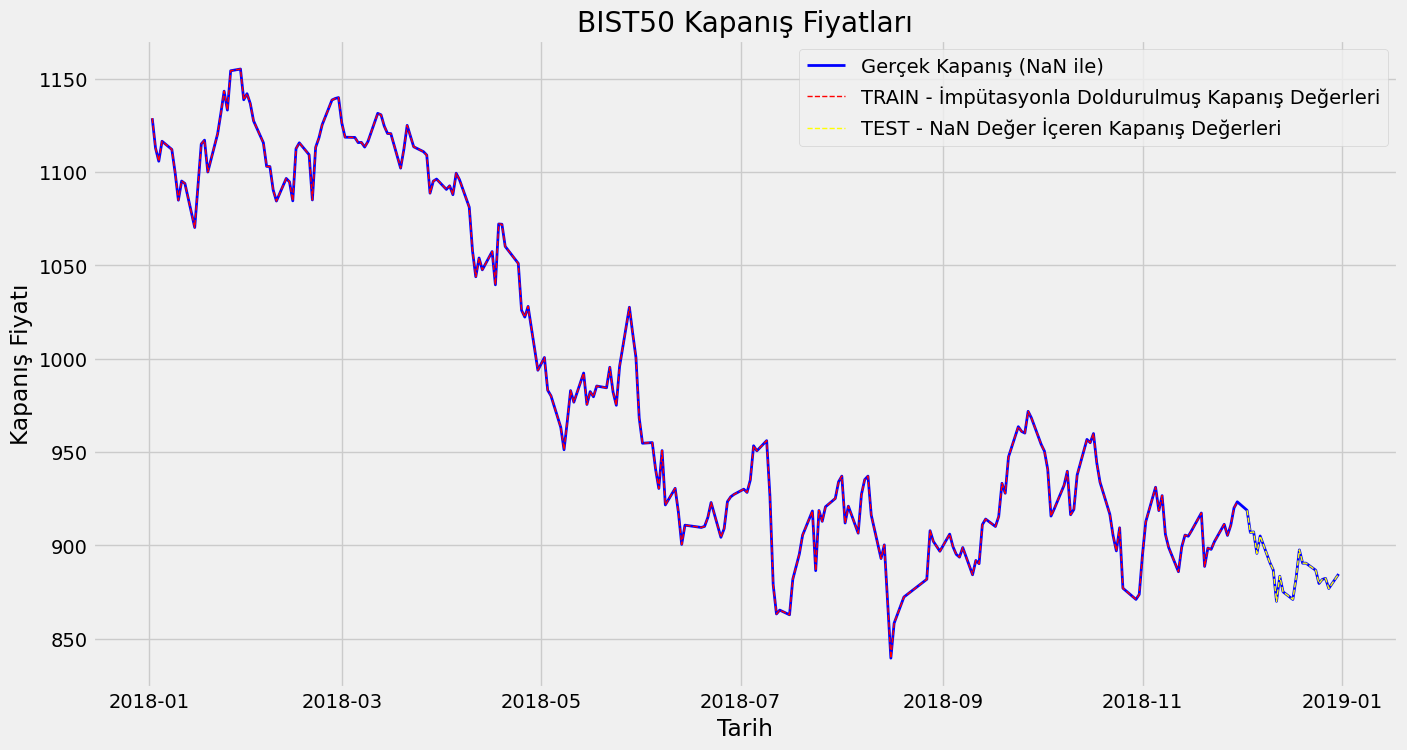

In [40]:
# Grafiği çizme
plt.figure(figsize=(15, 8))

# Orijinal Kapanış Fiyatlarını Çizme (NaN değerlerle)
plt.plot(full_df.index, full_df['Close'], label="Gerçek Kapanış (NaN ile)", color='blue', linestyle='-', linewidth=2)

# İmpütasyonla Doldurulmuş Değerleri Çizme - TRAIN verileri
plt.plot(final_df_grouped['Date'], final_df_grouped['Close'], label="TRAIN - İmpütasyonla Doldurulmuş Kapanış Değerleri", color='red', linestyle='--', linewidth=1)

# TEST verileri
plt.plot(test_data['Close'], label="TEST - NaN Değer İçeren Kapanış Değerleri", color='yellow', linestyle='--', linewidth=1)

plt.title("BIST50 Kapanış Fiyatları")
plt.xlabel("Tarih")
plt.ylabel("Kapanış Fiyatı")
plt.legend()
plt.show()

In [41]:
final_df_grouped

Date  Close_Normalized    Close
0   2018-01-02          0.916487  1128.88
1   2018-01-03          0.866018  1112.95
2   2018-01-04          0.843524  1105.85
3   2018-01-05          0.877424  1116.55
4   2018-01-08          0.863515  1112.16
..         ...               ...      ...
224 2018-11-26          0.227221   911.32
225 2018-11-27          0.208307   905.35
226 2018-11-28          0.225352   910.73
227 2018-11-29          0.255006   920.09
228 2018-11-30          0.265334   923.35

[229 rows x 3 columns]

In [42]:
# Date sütununu DataFrame'in indeksi olarak ayarlama
final_df_grouped.set_index('Date', inplace=True)

# Şimdi, 'Close' sütununu seçerek eğitim setini oluşturabiliriz.
train = final_df_grouped['Close'].to_frame()

# Sonuçları kontrol et
train.head()

Close
Date               
2018-01-02  1128.88
2018-01-03  1112.95
2018-01-04  1105.85
2018-01-05  1116.55
2018-01-08  1112.16

In [43]:
test = test_data[['Close']]
test.index.name = 'Date'
test

Close
Date              
2018-12-03  918.81
2018-12-04  906.93
2018-12-05  907.25
2018-12-06  895.73
2018-12-07  905.04
2018-12-10  890.69
2018-12-11  886.86
2018-12-12  870.05
2018-12-13  883.46
2018-12-14  875.14
2018-12-17  871.04
2018-12-18  882.59
2018-12-19  897.57
2018-12-20  890.45
2018-12-21  890.49
2018-12-24  886.69
2018-12-25  879.59
2018-12-26  881.76
2018-12-27  882.36
2018-12-28  876.93
2018-12-31  884.65

In [44]:
import numpy as np

# Differencing (1. dereceden fark)
train['Close_Diff'] = train['Close'].diff()

# Log Dönüşümü
train['Close_Log'] = np.log(train['Close'])

# Hareketli Ortalama (Feature Engineering)
train['Moving_Avg'] = train['Close'].rolling(window=3).mean()

# Smoothing işlemi (3 günlük)
train['Smoothed_Close'] = train['Close'].rolling(window=3).mean()

# NaN değerlerin çıkarılması
train = train.dropna()

# Son değerleri göster
print(train.tail().to_string())

             Close  Close_Diff  Close_Log  Moving_Avg  Smoothed_Close
Date                                                                 
2018-11-26  911.32        9.31   6.814894  903.733333      903.733333
2018-11-27  905.35       -5.97   6.808322  906.226667      906.226667
2018-11-28  910.73        5.38   6.814246  909.133333      909.133333
2018-11-29  920.09        9.36   6.824471  912.056667      912.056667
2018-11-30  923.35        3.26   6.828008  918.056667      918.056667


In [45]:
test

Close
Date              
2018-12-03  918.81
2018-12-04  906.93
2018-12-05  907.25
2018-12-06  895.73
2018-12-07  905.04
2018-12-10  890.69
2018-12-11  886.86
2018-12-12  870.05
2018-12-13  883.46
2018-12-14  875.14
2018-12-17  871.04
2018-12-18  882.59
2018-12-19  897.57
2018-12-20  890.45
2018-12-21  890.49
2018-12-24  886.69
2018-12-25  879.59
2018-12-26  881.76
2018-12-27  882.36
2018-12-28  876.93
2018-12-31  884.65

In [46]:
#statsmodels kütüphanesinin zaman serisi analizi için tarih indeksinin frekans bilgisinin verilmesi lazım
# train ve test DataFrame'lerinin indeksine günlük frekans atama
train.index = pd.DatetimeIndex(train.index).to_period('D')
test.index = pd.DatetimeIndex(test.index).to_period('D')

In [47]:
#matplotlib Period tipindeki tarih indeksini doğrudan desteklemediği için DatetimeIndex tipine çevirmemiz lazım
#df.index = df.index.to_timestamp()

In [48]:
# pmdarima zaten yukarıda yüklendi
# AutoARIMA için pmdarima kullanıyoruz

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


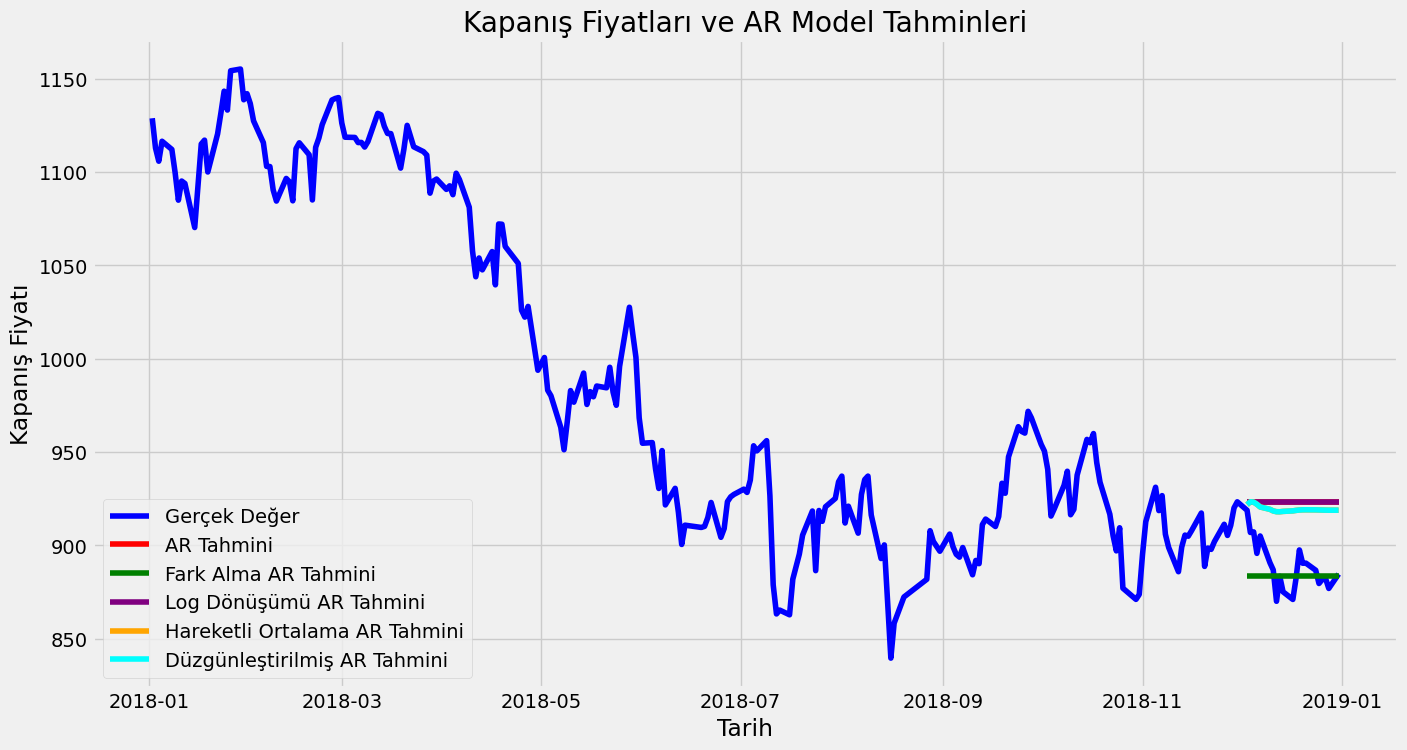

In [49]:
# Gerekli kütüphaneler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

# --- Yardımcı fonksiyon: pmdarima ile (p,d,q) seçimi ---
def get_auto_order(series, seasonal=False, start_p=0, max_p=2, start_q=0, max_q=2):
    model = auto_arima(series.dropna().values,
    seasonal=seasonal,
    start_p=start_p, max_p=max_p,
    start_q=start_q, max_q=max_q,
    suppress_warnings=True,
    error_action='ignore')
    return model.order

# --- AR Modelleri ---
# 1) Orijinal Close
order_close = get_auto_order(train['Close'])
predictions_ar = ARIMA(train['Close'], order=order_close).fit().forecast(steps=len(test))

# 2) Differencing
order_diff = get_auto_order(train['Close_Diff'])
predictions_ar_diff = ARIMA(train['Close_Diff'], order=order_diff).fit().forecast(steps=len(test))
predictions_ar_diff = predictions_ar_diff + test['Close'].iloc[-1]

# 3) Log dönüşümü
order_log = get_auto_order(train['Close_Log'])
predictions_ar_log = np.exp(ARIMA(train['Close_Log'], order=order_log).fit().forecast(steps=len(test)))

# 4) Hareketli ortalama
order_ma_feat = get_auto_order(train['Moving_Avg'])
predictions_ar_mov_avg = ARIMA(train['Moving_Avg'], order=order_ma_feat).fit().forecast(steps=len(test))

# 5) Düzgünleştirilmiş seri
smooth_series = train['Smoothed_Close'].dropna()
order_smooth = get_auto_order(smooth_series)
predictions_ar_smooth = ARIMA(smooth_series, order=order_smooth).fit().forecast(steps=len(test))

# --- Grafik ---
plt.figure(figsize=(15,8))
plt.plot(df.index, df['Close'], label='Gerçek Değer', color='blue')
plt.plot(test.index, predictions_ar, label='AR Tahmini', color='red')
plt.plot(test.index, predictions_ar_diff, label='Fark Alma AR Tahmini', color='green')
plt.plot(test.index, predictions_ar_log, label='Log Dönüşümü AR Tahmini', color='purple')
plt.plot(test.index, predictions_ar_mov_avg, label='Hareketli Ortalama AR Tahmini', color='orange')
plt.plot(test.index, predictions_ar_smooth, label='Düzgünleştirilmiş AR Tahmini', color='cyan')

plt.title('Kapanış Fiyatları ve AR Model Tahminleri')
plt.xlabel('Tarih')
plt.ylabel('Kapanış Fiyatı')
plt.legend(loc='lower left')
plt.show()

In [50]:
# AR Modeli - pmdarima ile otomatik order seçimi zaten yapıldı
# Bu hücre Cell 57'deki güncel kodla değiştirildi
print("AR modelleri Cell 57'de çalıştırıldı.")

AR modelleri Cell 57'de çalıştırıldı.


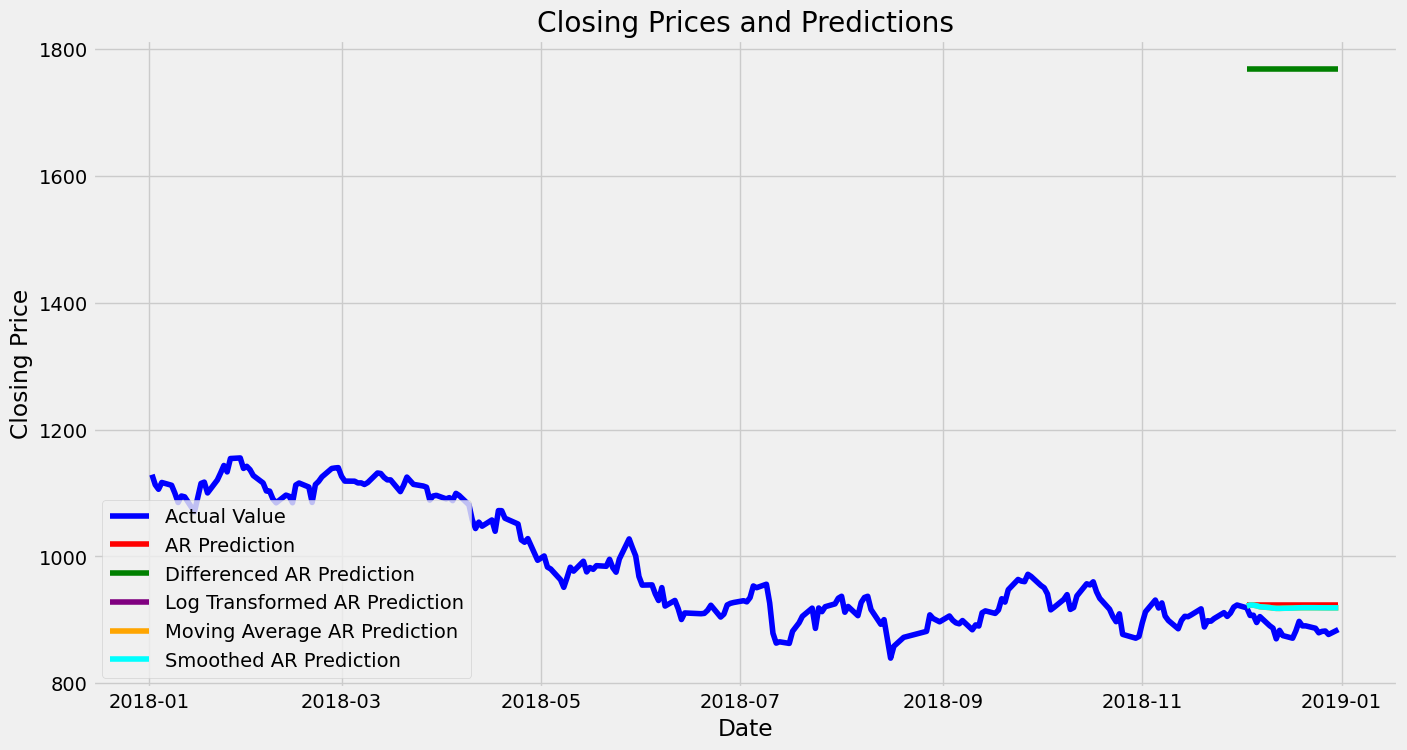

In [51]:
# AR Modeli (İngilizce)
# Grafik Oluşturma
plt.figure(figsize=(15,8))
plt.plot(df.index, df['Close'], label='Actual Value', color='blue')
plt.plot(test.index, predictions_ar, label='AR Prediction', color='red')
plt.plot(test.index, predictions_ar_diff.add(test['Close'].iloc[-1]), label='Differenced AR Prediction', color='green')
plt.plot(test.index, np.exp(predictions_ar_log), label='Log Transformed AR Prediction', color='purple')
plt.plot(test.index, predictions_ar_mov_avg, label='Moving Average AR Prediction', color='orange')
plt.plot(test.index, predictions_ar_smooth, label='Smoothed AR Prediction', color='cyan')

# Başlık ve Etiketler
plt.title('Closing Prices and Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(loc='lower left')

# Grafik Gösterimi
plt.show()

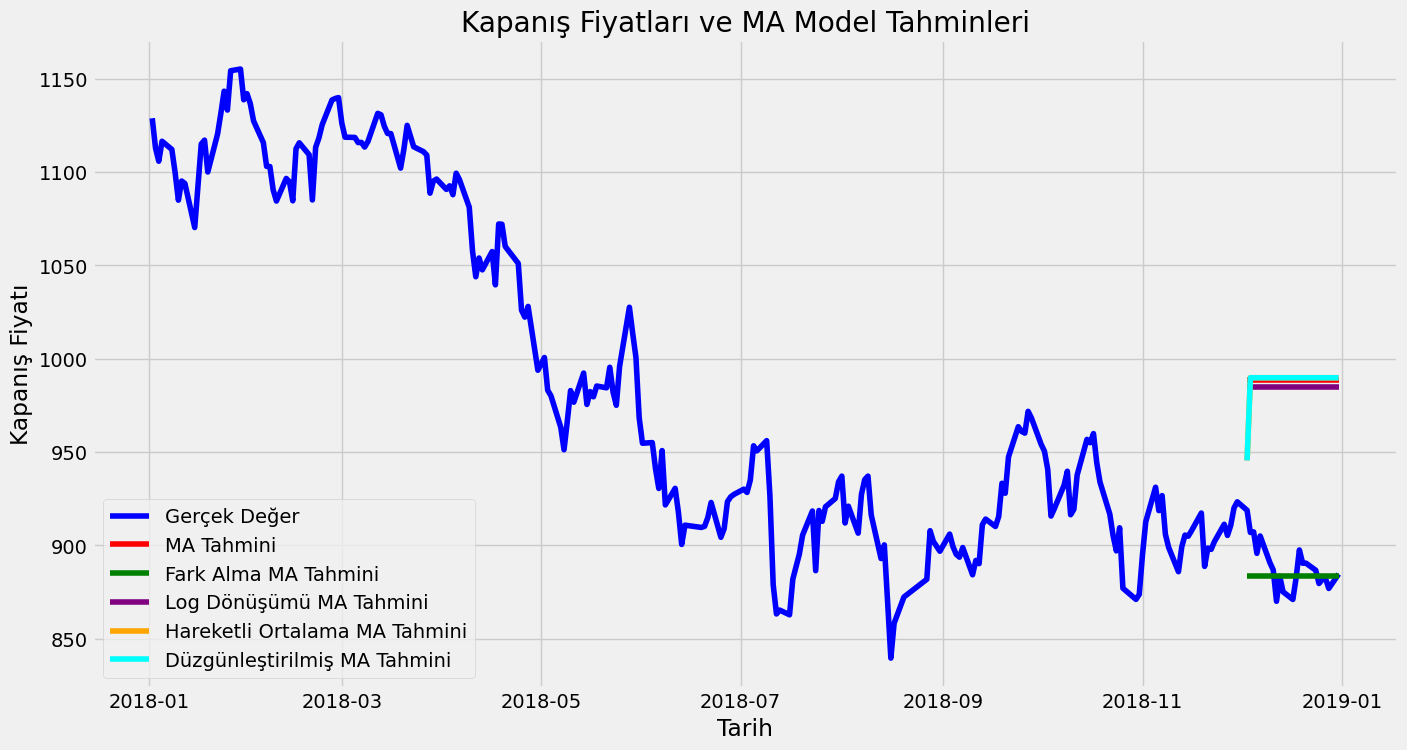

In [52]:
# MA Modelleri (pmdarima ile)
# 1) Orijinal Close - MA
q_close = get_auto_order(train['Close'])[2] # Sadece q değerini al
predictions_ma = ARIMA(train['Close'], order=(0, 0, q_close)).fit().forecast(steps=len(test))

# 2) Differencing - MA
q_diff = get_auto_order(train['Close_Diff'])[2]
predictions_ma_diff = ARIMA(train['Close_Diff'], order=(0, 0, q_diff)).fit().forecast(steps=len(test))

# 3) Log dönüşümü - MA
q_log = get_auto_order(train['Close_Log'])[2]
predictions_ma_log = ARIMA(train['Close_Log'], order=(0, 0, q_log)).fit().forecast(steps=len(test))

# 4) Hareketli ortalama - MA
q_mov = get_auto_order(train['Moving_Avg'])[2]
predictions_ma_mov_avg = ARIMA(train['Moving_Avg'], order=(0, 0, q_mov)).fit().forecast(steps=len(test))

# 5) Düzgünleştirilmiş - MA
q_smooth = get_auto_order(smooth_series)[2]
predictions_ma_smooth = ARIMA(smooth_series, order=(0, 0, q_smooth)).fit().forecast(steps=len(test))

# Grafik
plt.figure(figsize=(15,8))
plt.plot(df.index, df['Close'], label='Gerçek Değer', color='blue')
plt.plot(test.index, predictions_ma, label='MA Tahmini', color='red')
plt.plot(test.index, predictions_ma_diff + test['Close'].iloc[-1], label='Fark Alma MA Tahmini', color='green')
plt.plot(test.index, np.exp(predictions_ma_log), label='Log Dönüşümü MA Tahmini', color='purple')
plt.plot(test.index, predictions_ma_mov_avg, label='Hareketli Ortalama MA Tahmini', color='orange')
plt.plot(test.index, predictions_ma_smooth, label='Düzgünleştirilmiş MA Tahmini', color='cyan')

plt.title('Kapanış Fiyatları ve MA Model Tahminleri')
plt.xlabel('Tarih')
plt.ylabel('Kapanış Fiyatı')
plt.legend(loc='lower left')
plt.show()

In [53]:
# Bu hücre artık kullanılmıyor
# pmdarima ile get_auto_order fonksiyonu Cell 57'de tanımlandı
print("Helper fonksiyonlar Cell 57'de tanımlandı.")

Helper fonksiyonlar Cell 57'de tanımlandı.


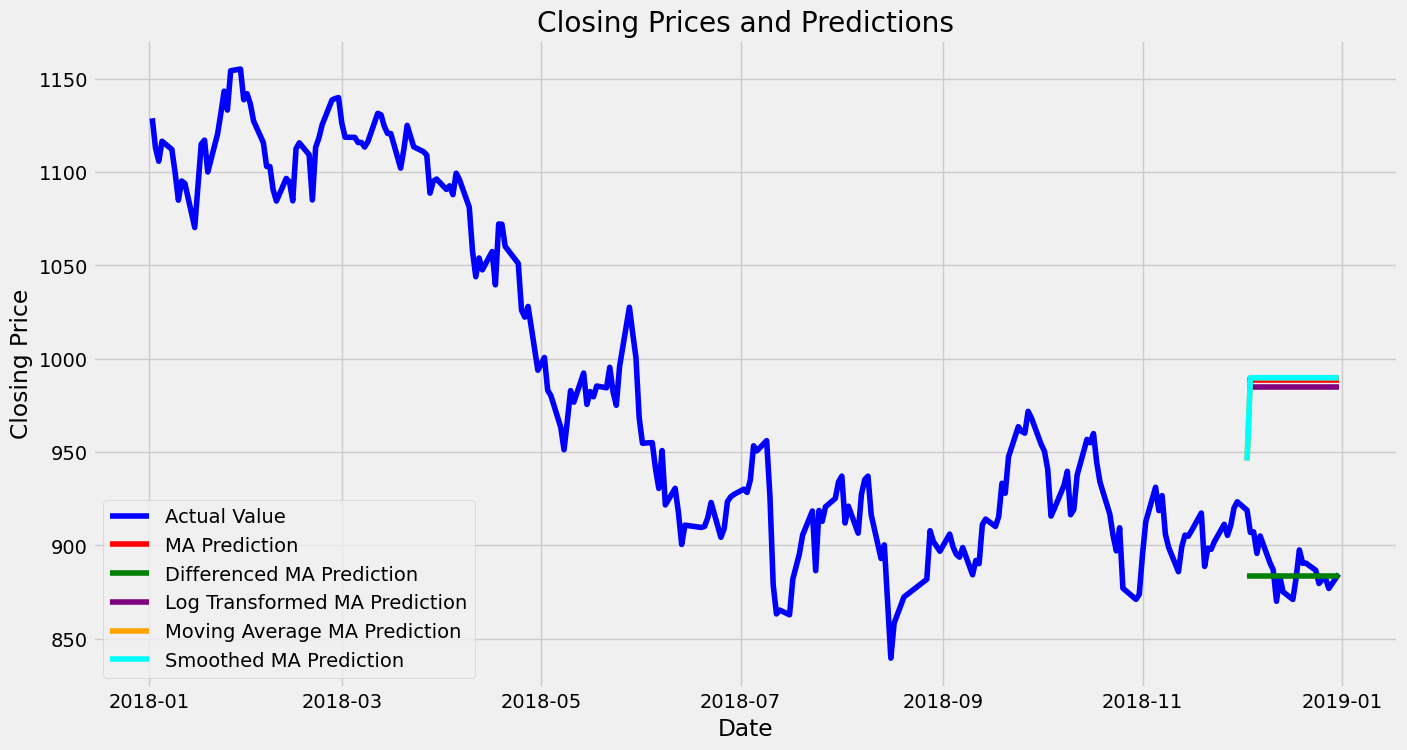

In [54]:
# MA Modeli (İngilizce)
# Grafik Oluşturma
plt.figure(figsize=(15,8))
plt.plot(df.index, df['Close'], label='Actual Value', color='blue')
plt.plot(test.index, predictions_ma, label='MA Prediction', color='red')
plt.plot(test.index, predictions_ma_diff.add(test['Close'].iloc[-1]), label='Differenced MA Prediction', color='green')
plt.plot(test.index, np.exp(predictions_ma_log), label='Log Transformed MA Prediction', color='purple')
plt.plot(test.index, predictions_ma_mov_avg, label='Moving Average MA Prediction', color='orange')
plt.plot(test.index, predictions_ma_smooth, label='Smoothed MA Prediction', color='cyan')

# Başlık ve Etiketler
plt.title('Closing Prices and Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(loc='lower left')

# Grafik Gösterimi
plt.show()


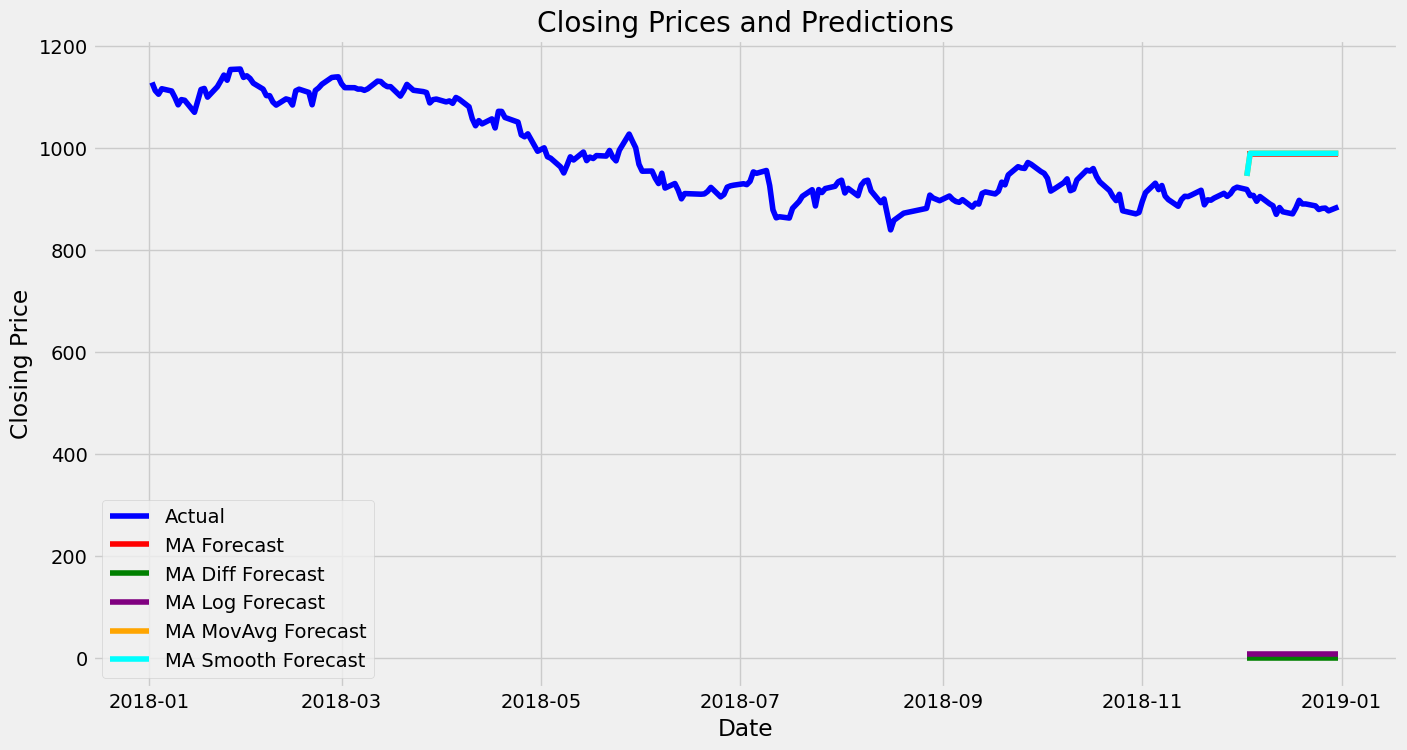

In [55]:
# MA Modeli – İngilizce grafik
plt.figure(figsize=(15, 8))
plt.plot(df.index, df["Close"], label="Actual", color="blue")
plt.plot(test.index, predictions_ma, label="MA Forecast", color="red")
plt.plot(test.index, predictions_ma_diff, label="MA Diff Forecast", color="green")
plt.plot(test.index, predictions_ma_log, label="MA Log Forecast", color="purple")
plt.plot(test.index, predictions_ma_mov_avg, label="MA MovAvg Forecast", color="orange")
plt.plot(test.index, predictions_ma_smooth, label="MA Smooth Forecast", color="cyan")

plt.title("Closing Prices and Predictions")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend(loc="lower left")
plt.show()


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


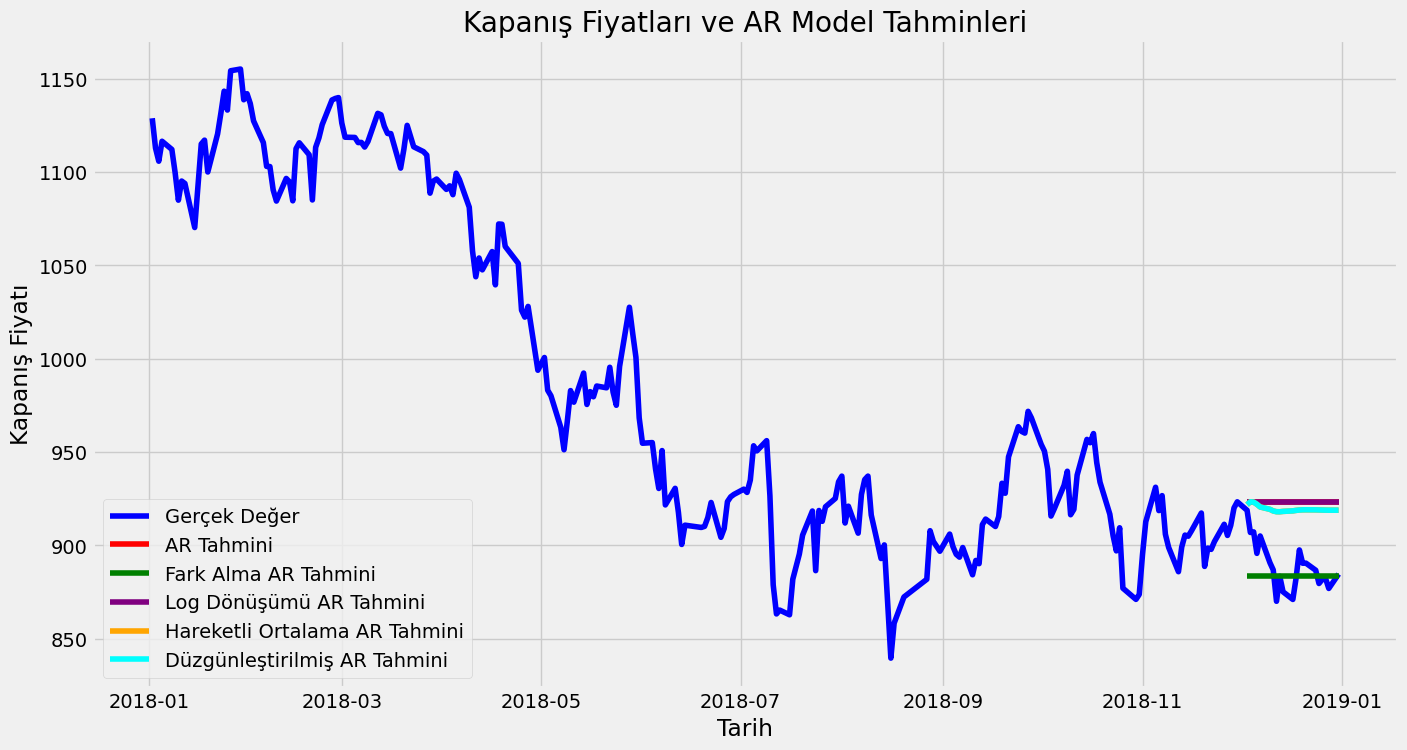

In [56]:
# Gerekli kütüphaneler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

# --- Yardımcı fonksiyon: pmdarima ile (p,d,q) seçimi ---
def get_auto_order(series, seasonal=False, start_p=0, max_p=2, start_q=0, max_q=2):
    model = auto_arima(series.dropna().values,
    seasonal=seasonal,
    start_p=start_p, max_p=max_p,
    start_q=start_q, max_q=max_q,
    suppress_warnings=True,
    error_action='ignore')
    return model.order

# --- AR Modelleri ---
# 1) Orijinal Close
order_close = get_auto_order(train['Close'])
predictions_ar = ARIMA(train['Close'], order=order_close).fit().forecast(steps=len(test))

# 2) Differencing
order_diff = get_auto_order(train['Close_Diff'])
predictions_ar_diff = ARIMA(train['Close_Diff'], order=order_diff).fit().forecast(steps=len(test))
predictions_ar_diff = predictions_ar_diff + test['Close'].iloc[-1]

# 3) Log dönüşümü
order_log = get_auto_order(train['Close_Log'])
predictions_ar_log = np.exp(ARIMA(train['Close_Log'], order=order_log).fit().forecast(steps=len(test)))

# 4) Hareketli ortalama
order_ma_feat = get_auto_order(train['Moving_Avg'])
predictions_ar_mov_avg = ARIMA(train['Moving_Avg'], order=order_ma_feat).fit().forecast(steps=len(test))

# 5) Düzgünleştirilmiş seri
smooth_series = train['Smoothed_Close'].dropna()
order_smooth = get_auto_order(smooth_series)
predictions_ar_smooth = ARIMA(smooth_series, order=order_smooth).fit().forecast(steps=len(test))

# --- Grafik ---
plt.figure(figsize=(15,8))
plt.plot(df.index, df['Close'], label='Gerçek Değer', color='blue')
plt.plot(test.index, predictions_ar, label='AR Tahmini', color='red')
plt.plot(test.index, predictions_ar_diff, label='Fark Alma AR Tahmini', color='green')
plt.plot(test.index, predictions_ar_log, label='Log Dönüşümü AR Tahmini', color='purple')
plt.plot(test.index, predictions_ar_mov_avg, label='Hareketli Ortalama AR Tahmini', color='orange')
plt.plot(test.index, predictions_ar_smooth, label='Düzgünleştirilmiş AR Tahmini', color='cyan')

plt.title('Kapanış Fiyatları ve AR Model Tahminleri')
plt.xlabel('Tarih')
plt.ylabel('Kapanış Fiyatı')
plt.legend(loc='lower left')
plt.show()

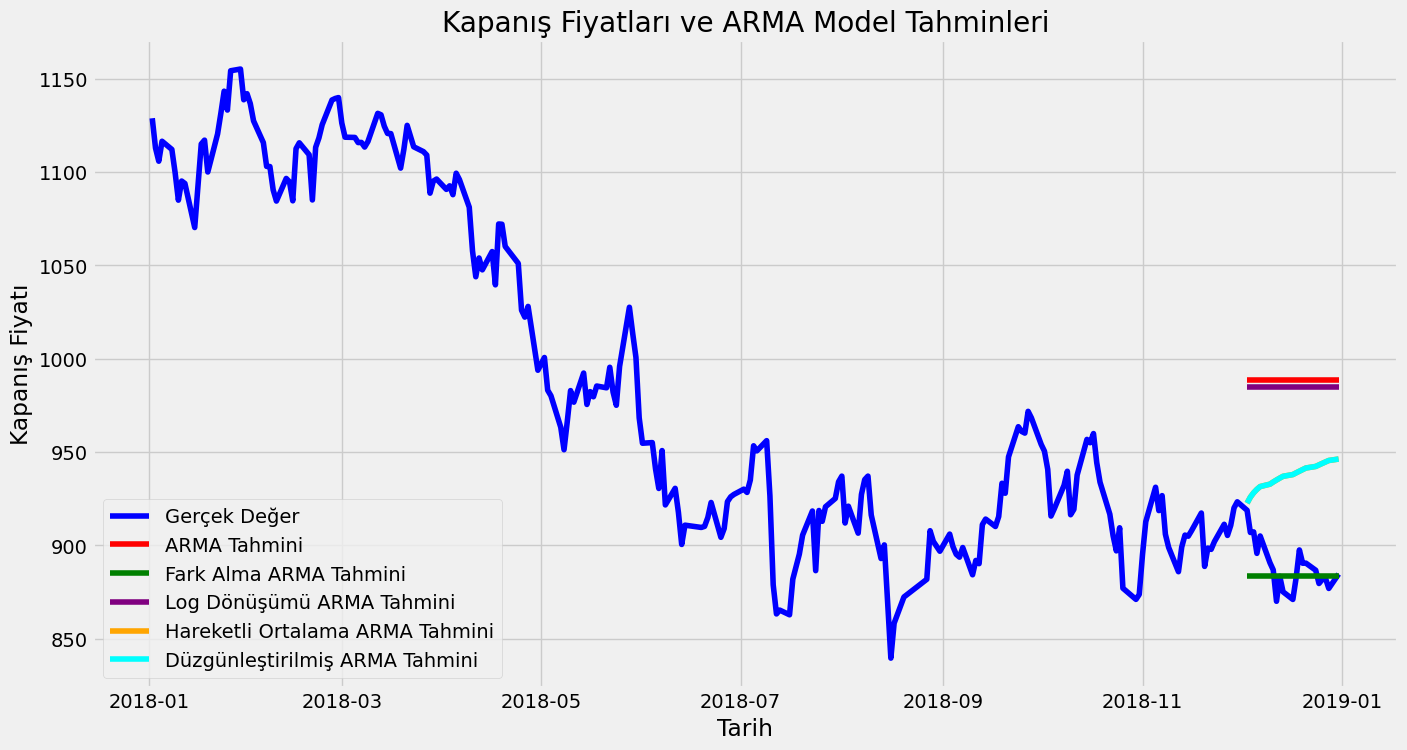

In [57]:
# ARMA Modelleri (pmdarima ile)
# get_auto_order fonksiyonu Cell 57'de tanımlandı

# 1) Orijinal Close - ARMA (p,0,q)
p_close, d_close, q_close = get_auto_order(train['Close'])
predictions_arma = ARIMA(train['Close'], order=(p_close, 0, q_close)).fit().forecast(steps=len(test))

# 2) Differencing - ARMA
p_diff, d_diff, q_diff = get_auto_order(train['Close_Diff'])
pred_arma_diff = ARIMA(train['Close_Diff'], order=(p_diff, 0, q_diff)).fit().forecast(steps=len(test))
predictions_arma_diff = pred_arma_diff + test['Close'].iloc[-1]

# 3) Log dönüşümü - ARMA
p_log, d_log, q_log = get_auto_order(train['Close_Log'])
predictions_arma_log = np.exp(ARIMA(train['Close_Log'], order=(p_log, 0, q_log)).fit().forecast(steps=len(test)))

# 4) Hareketli ortalama - ARMA
p_mov, d_mov, q_mov = get_auto_order(train['Moving_Avg'])
predictions_arma_mov_avg = ARIMA(train['Moving_Avg'], order=(p_mov, 0, q_mov)).fit().forecast(steps=len(test))

# 5) Düzgünleştirilmiş - ARMA
p_smooth, d_smooth, q_smooth = get_auto_order(smooth_series)
predictions_arma_smooth = ARIMA(smooth_series, order=(p_smooth, 0, q_smooth)).fit().forecast(steps=len(test))

# Grafik
plt.figure(figsize=(15,8))
plt.plot(df.index, df['Close'], label='Gerçek Değer', color='blue')
plt.plot(test.index, predictions_arma, label='ARMA Tahmini', color='red')
plt.plot(test.index, predictions_arma_diff, label='Fark Alma ARMA Tahmini', color='green')
plt.plot(test.index, predictions_arma_log, label='Log Dönüşümü ARMA Tahmini', color='purple')
plt.plot(test.index, predictions_arma_mov_avg, label='Hareketli Ortalama ARMA Tahmini', color='orange')
plt.plot(test.index, predictions_arma_smooth, label='Düzgünleştirilmiş ARMA Tahmini', color='cyan')

plt.title('Kapanış Fiyatları ve ARMA Model Tahminleri')
plt.xlabel('Tarih')
plt.ylabel('Kapanış Fiyatı')
plt.legend(loc='lower left')
plt.show()

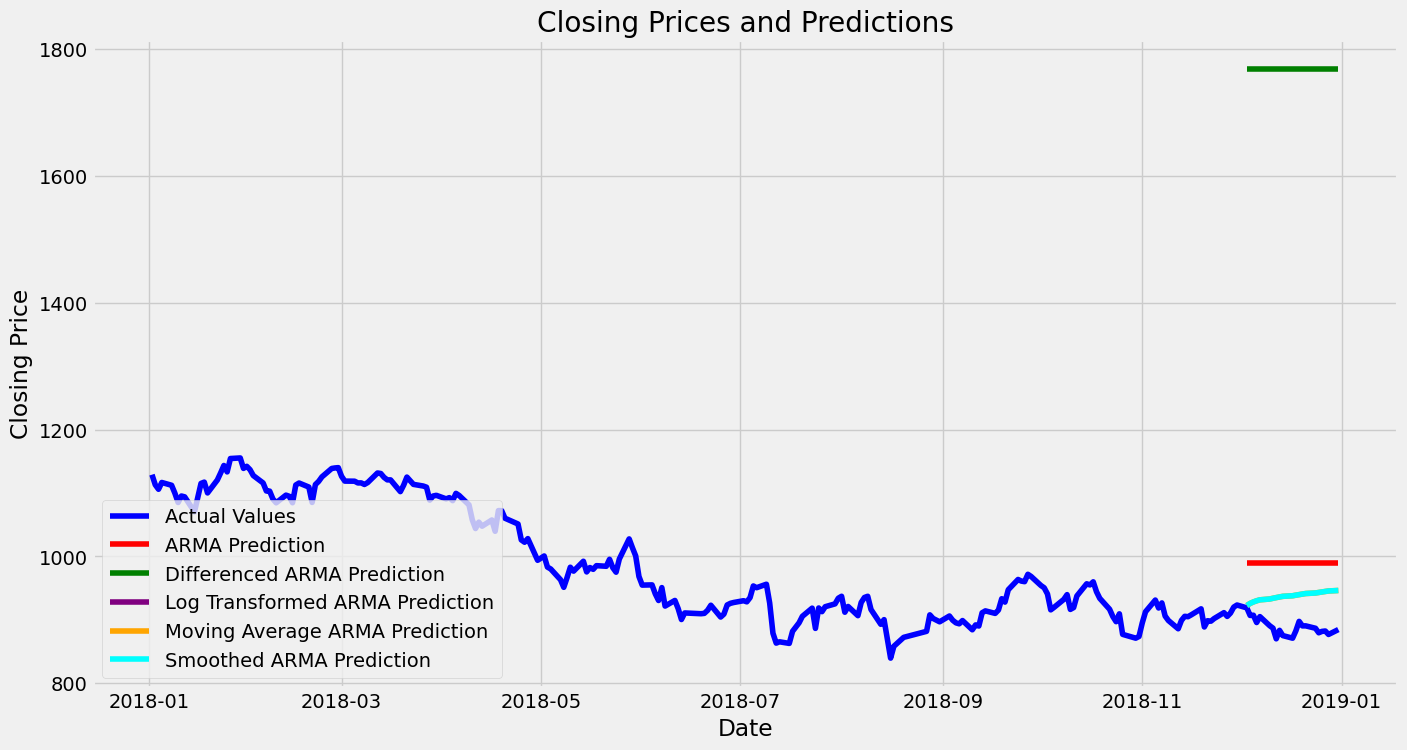

In [58]:
# ARMA Modeli (İngilizce)

# ARMA Modeli için Grafik Oluşturma
plt.figure(figsize=(15,8))
plt.plot(df.index, df['Close'], label='Actual Values', color='blue')
plt.plot(test.index, predictions_arma, label='ARMA Prediction', color='red')
plt.plot(test.index, predictions_arma_diff.add(test['Close'].iloc[-1]), label='Differenced ARMA Prediction', color='green')
plt.plot(test.index, np.exp(predictions_arma_log), label='Log Transformed ARMA Prediction', color='purple')
plt.plot(test.index, predictions_arma_mov_avg, label='Moving Average ARMA Prediction', color='orange')
plt.plot(test.index, predictions_arma_smooth, label='Smoothed ARMA Prediction', color='cyan')


# Başlık ve Etiketler
plt.title('Closing Prices and Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(loc='lower left')

# Grafik Gösterimi
plt.show()

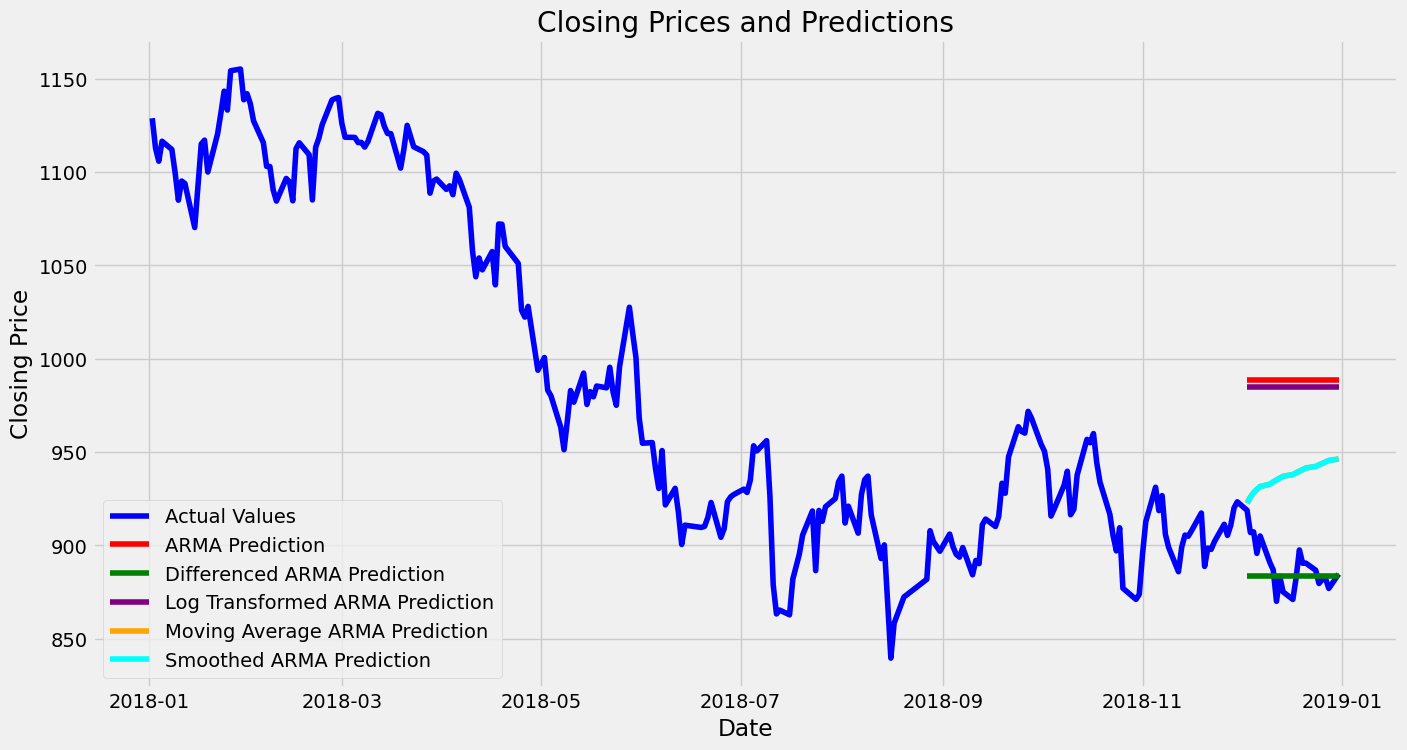

In [59]:
# ARMA Modeli – English version with updated variable names
plt.figure(figsize=(15, 8))
plt.plot(df.index, df["Close"], label="Actual Values", color="blue")
plt.plot(test.index, predictions_arma, label="ARMA Prediction", color="red")
plt.plot(test.index, predictions_arma_diff, label="Differenced ARMA Prediction",color="green")
plt.plot(test.index, predictions_arma_log, label="Log Transformed ARMA Prediction", color="purple")
plt.plot(test.index, predictions_arma_mov_avg, label="Moving Average ARMA Prediction", color="orange")
plt.plot(test.index, predictions_arma_smooth, label="Smoothed ARMA Prediction", color="cyan")

plt.title("Closing Prices and Predictions")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend(loc="lower left")
plt.show()


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


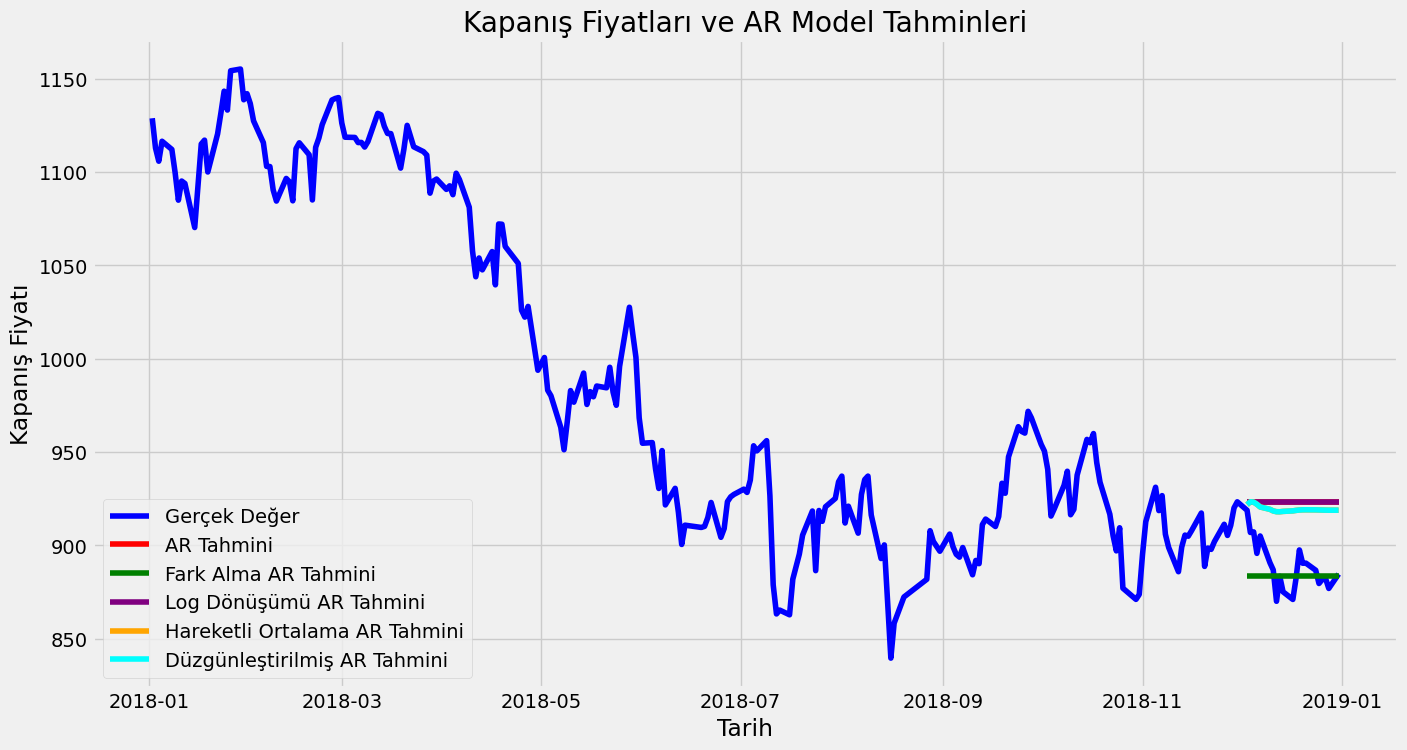

In [60]:
# Gerekli kütüphaneler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

# --- Yardımcı fonksiyon: pmdarima ile (p,d,q) seçimi ---
def get_auto_order(series, seasonal=False, start_p=0, max_p=2, start_q=0, max_q=2):
    model = auto_arima(series.dropna().values,
    seasonal=seasonal,
    start_p=start_p, max_p=max_p,
    start_q=start_q, max_q=max_q,
    suppress_warnings=True,
    error_action='ignore')
    return model.order

# --- AR Modelleri ---
# 1) Orijinal Close
order_close = get_auto_order(train['Close'])
predictions_ar = ARIMA(train['Close'], order=order_close).fit().forecast(steps=len(test))

# 2) Differencing
order_diff = get_auto_order(train['Close_Diff'])
predictions_ar_diff = ARIMA(train['Close_Diff'], order=order_diff).fit().forecast(steps=len(test))
predictions_ar_diff = predictions_ar_diff + test['Close'].iloc[-1]

# 3) Log dönüşümü
order_log = get_auto_order(train['Close_Log'])
predictions_ar_log = np.exp(ARIMA(train['Close_Log'], order=order_log).fit().forecast(steps=len(test)))

# 4) Hareketli ortalama
order_ma_feat = get_auto_order(train['Moving_Avg'])
predictions_ar_mov_avg = ARIMA(train['Moving_Avg'], order=order_ma_feat).fit().forecast(steps=len(test))

# 5) Düzgünleştirilmiş seri
smooth_series = train['Smoothed_Close'].dropna()
order_smooth = get_auto_order(smooth_series)
predictions_ar_smooth = ARIMA(smooth_series, order=order_smooth).fit().forecast(steps=len(test))

# --- Grafik ---
plt.figure(figsize=(15,8))
plt.plot(df.index, df['Close'], label='Gerçek Değer', color='blue')
plt.plot(test.index, predictions_ar, label='AR Tahmini', color='red')
plt.plot(test.index, predictions_ar_diff, label='Fark Alma AR Tahmini', color='green')
plt.plot(test.index, predictions_ar_log, label='Log Dönüşümü AR Tahmini', color='purple')
plt.plot(test.index, predictions_ar_mov_avg, label='Hareketli Ortalama AR Tahmini', color='orange')
plt.plot(test.index, predictions_ar_smooth, label='Düzgünleştirilmiş AR Tahmini', color='cyan')

plt.title('Kapanış Fiyatları ve AR Model Tahminleri')
plt.xlabel('Tarih')
plt.ylabel('Kapanış Fiyatı')
plt.legend(loc='lower left')
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


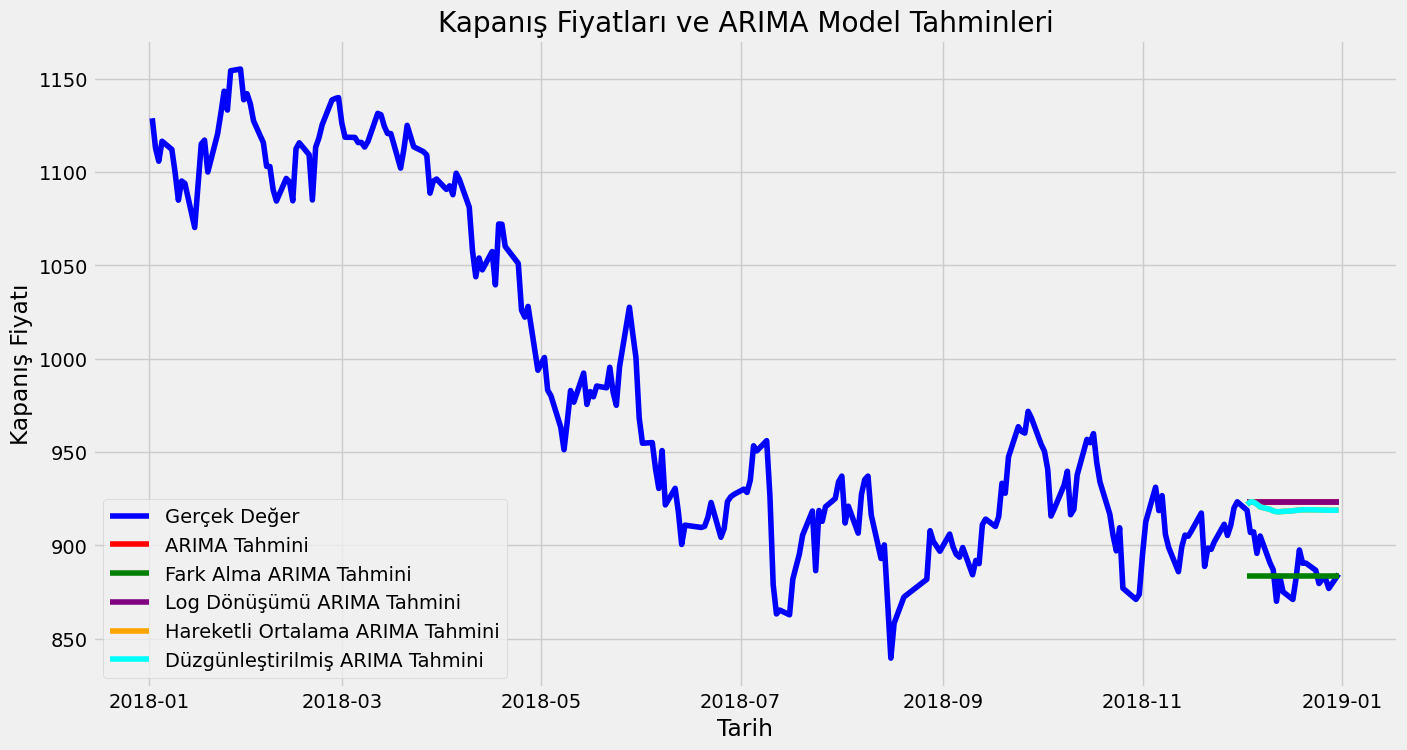

In [61]:
# ARIMA Modelleri (pmdarima ile)
# get_auto_order fonksiyonu Cell 57'de tanımlandı

# 1) Orijinal Close - ARIMA
order_arima = get_auto_order(train['Close'])
predictions_arima = ARIMA(train['Close'], order=order_arima).fit().forecast(steps=len(test))

# 2) Differencing - ARIMA
order_arima_diff = get_auto_order(train['Close_Diff'])
pred_arima_diff = ARIMA(train['Close_Diff'], order=order_arima_diff).fit().forecast(steps=len(test))
predictions_arima_diff = pred_arima_diff + test['Close'].iloc[-1]

# 3) Log dönüşümü - ARIMA
order_arima_log = get_auto_order(train['Close_Log'])
predictions_arima_log = np.exp(ARIMA(train['Close_Log'], order=order_arima_log).fit().forecast(steps=len(test)))

# 4) Hareketli ortalama - ARIMA
order_arima_mov = get_auto_order(train['Moving_Avg'])
predictions_arima_mov_avg = ARIMA(train['Moving_Avg'], order=order_arima_mov).fit().forecast(steps=len(test))

# 5) Düzgünleştirilmiş - ARIMA
order_arima_smooth = get_auto_order(smooth_series)
predictions_arima_smooth = ARIMA(smooth_series, order=order_arima_smooth).fit().forecast(steps=len(test))

# Grafik
plt.figure(figsize=(15,8))
plt.plot(df.index, df['Close'], label='Gerçek Değer', color='blue')
plt.plot(test.index, predictions_arima, label='ARIMA Tahmini', color='red')
plt.plot(test.index, predictions_arima_diff, label='Fark Alma ARIMA Tahmini', color='green')
plt.plot(test.index, predictions_arima_log, label='Log Dönüşümü ARIMA Tahmini', color='purple')
plt.plot(test.index, predictions_arima_mov_avg, label='Hareketli Ortalama ARIMA Tahmini', color='orange')
plt.plot(test.index, predictions_arima_smooth, label='Düzgünleştirilmiş ARIMA Tahmini', color='cyan')

plt.title('Kapanış Fiyatları ve ARIMA Model Tahminleri')
plt.xlabel('Tarih')
plt.ylabel('Kapanış Fiyatı')
plt.legend(loc='lower left')
plt.show()

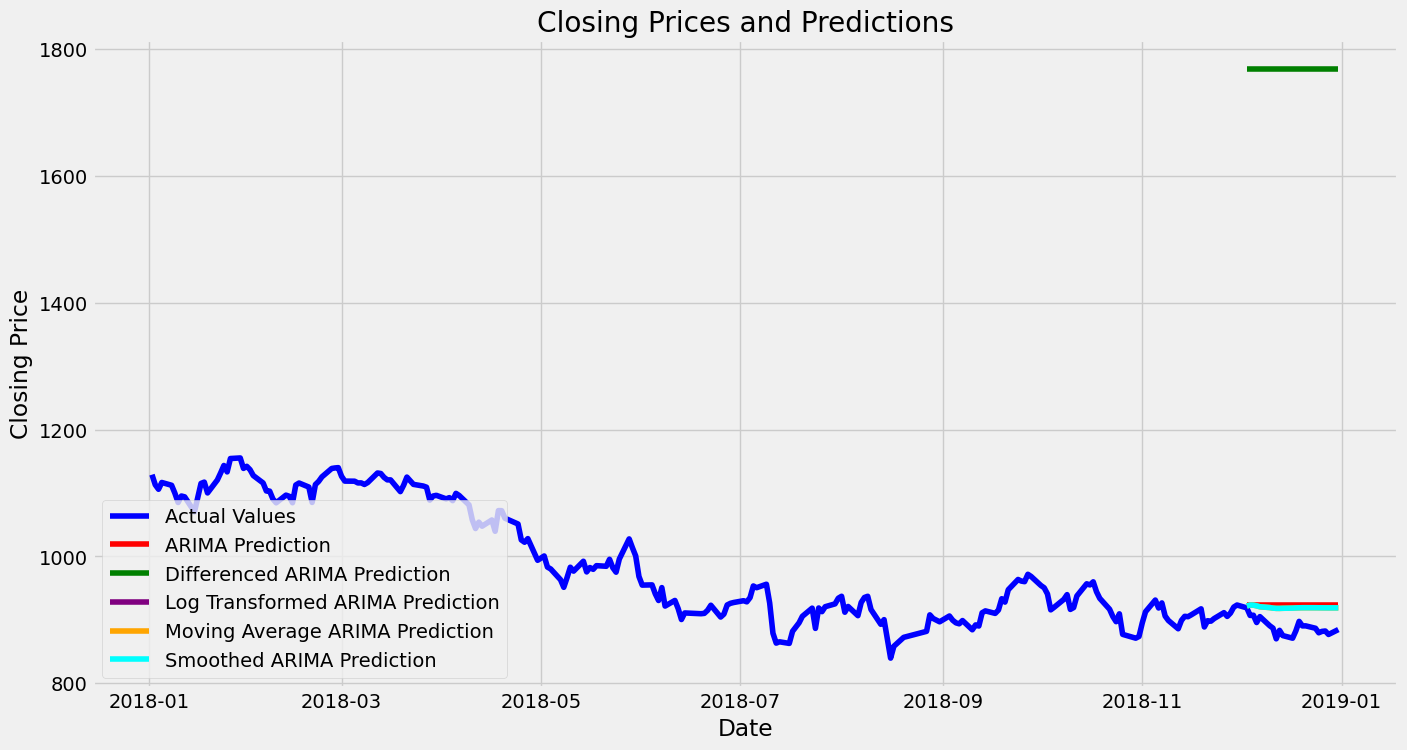

In [62]:
# ARIMA Modeli için Grafik Oluşturma
plt.figure(figsize=(15,8))
plt.plot(df.index, df['Close'], label='Actual Values', color='blue')
plt.plot(test.index, predictions_arima, label='ARIMA Prediction', color='red')
plt.plot(test.index, predictions_arima_diff.add(test['Close'].iloc[-1]), label='Differenced ARIMA Prediction', color='green')
plt.plot(test.index, np.exp(predictions_arima_log), label='Log Transformed ARIMA Prediction', color='purple')
plt.plot(test.index, predictions_arima_mov_avg, label='Moving Average ARIMA Prediction', color='orange')
plt.plot(test.index, predictions_arima_smooth, label='Smoothed ARIMA Prediction', color='cyan')


# Başlık ve Etiketler
plt.title('Closing Prices and Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(loc='lower left')

# Grafik Gösterimi
plt.show()

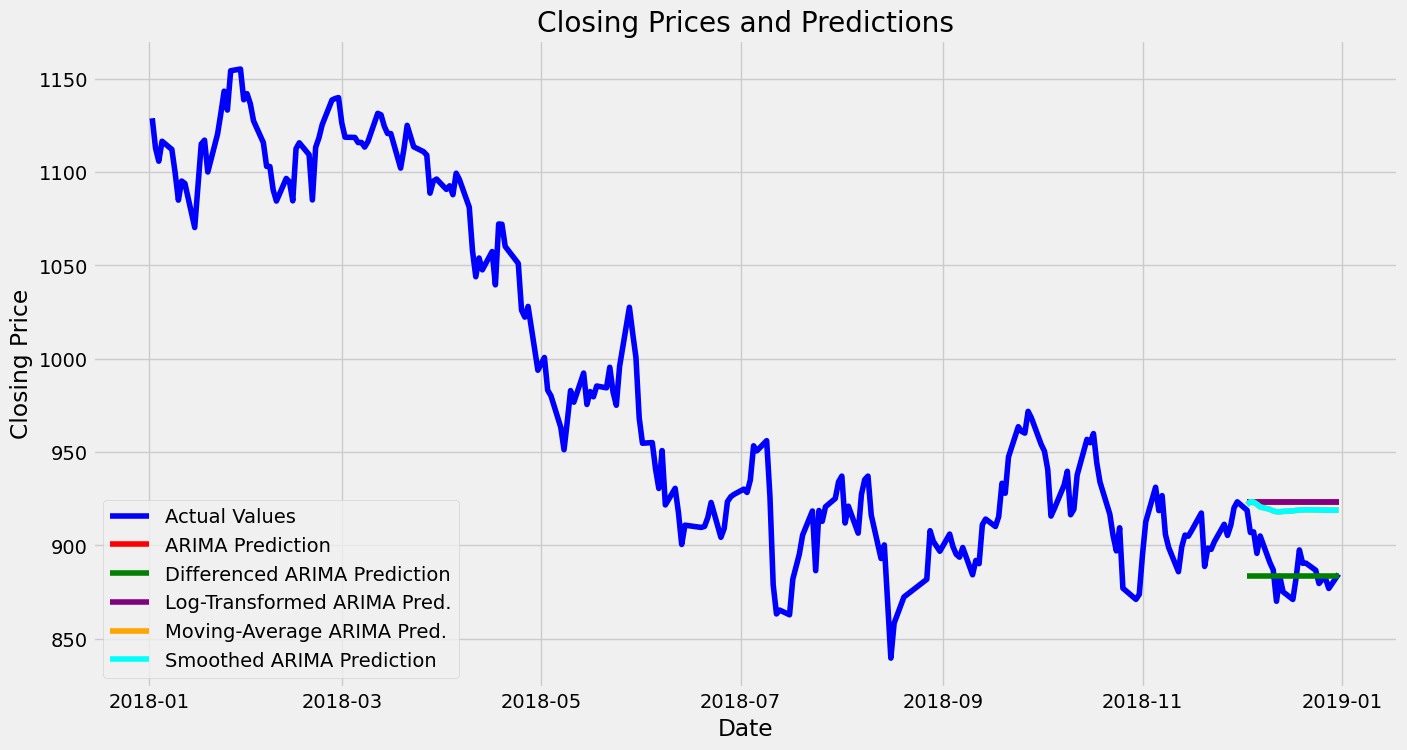

In [63]:
# ARIMA Modeli – İngilizce grafik (güncel değişken adlarıyla)
plt.figure(figsize=(15, 8))
plt.plot(df.index, df["Close"], label="Actual Values", color="blue")
plt.plot(test.index, predictions_arima, label="ARIMA Prediction", color="red")
plt.plot(test.index, predictions_arima_diff, label="Differenced ARIMA Prediction", color="green")
plt.plot(test.index, predictions_arima_log, label="Log-Transformed ARIMA Pred.", color="purple")
plt.plot(test.index, predictions_arima_mov_avg, label="Moving-Average ARIMA Pred.", color="orange")
plt.plot(test.index, predictions_arima_smooth, label="Smoothed ARIMA Prediction", color="cyan")

plt.title("Closing Prices and Predictions")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend(loc="lower left")
plt.show()


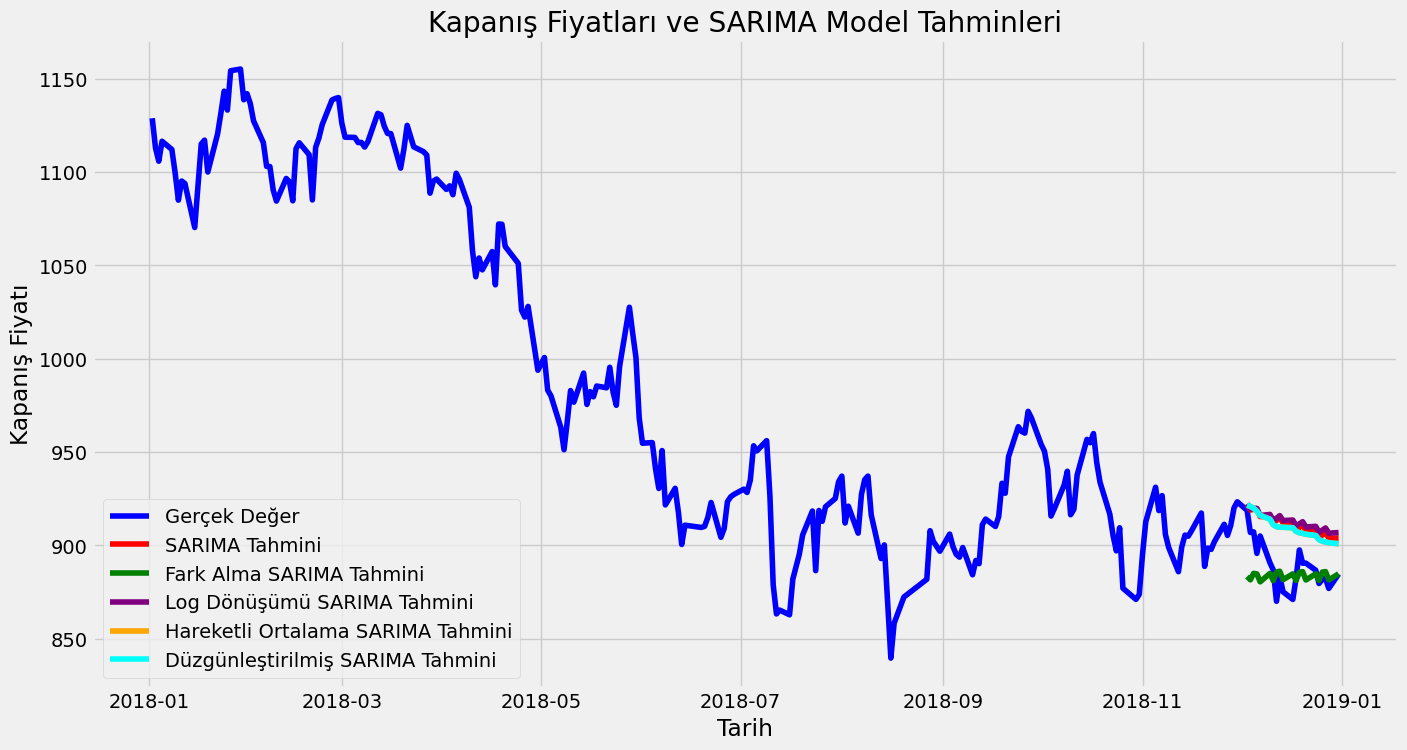

In [64]:
# SARIMA Modelleri (pmdarima ile)
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Mevsimsel parametreler
seasonal_order = (1, 1, 1, 5) # Haftalık mevsimsellik (5 iş günü)

# 1) Orijinal Close - SARIMA
order_sar = get_auto_order(train['Close'])
predictions_sarima = SARIMAX(train['Close'], order=order_sar, seasonal_order=seasonal_order).fit(disp=False).forecast(steps=len(test))

# 2) Differencing - SARIMA
order_sar_diff = get_auto_order(train['Close_Diff'])
predictions_sarima_diff = SARIMAX(train['Close_Diff'], order=order_sar_diff, seasonal_order=seasonal_order).fit(disp=False).forecast(steps=len(test))
predictions_sarima_diff = predictions_sarima_diff + test['Close'].iloc[-1]

# 3) Log dönüşümü - SARIMA
order_sar_log = get_auto_order(train['Close_Log'])
predictions_sarima_log = np.exp(SARIMAX(train['Close_Log'], order=order_sar_log, seasonal_order=seasonal_order).fit(disp=False).forecast(steps=len(test)))

# 4) Hareketli ortalama - SARIMA
order_sar_mov = get_auto_order(train['Moving_Avg'])
predictions_sarima_mov_avg = SARIMAX(train['Moving_Avg'], order=order_sar_mov, seasonal_order=seasonal_order).fit(disp=False).forecast(steps=len(test))

# 5) Düzgünleştirilmiş - SARIMA
order_sar_smooth = get_auto_order(smooth_series)
predictions_sarima_smooth = SARIMAX(smooth_series, order=order_sar_smooth, seasonal_order=seasonal_order).fit(disp=False).forecast(steps=len(test))

# Grafik
plt.figure(figsize=(15,8))
plt.plot(df.index, df['Close'], label='Gerçek Değer', color='blue')
plt.plot(test.index, predictions_sarima, label='SARIMA Tahmini', color='red')
plt.plot(test.index, predictions_sarima_diff, label='Fark Alma SARIMA Tahmini', color='green')
plt.plot(test.index, predictions_sarima_log, label='Log Dönüşümü SARIMA Tahmini', color='purple')
plt.plot(test.index, predictions_sarima_mov_avg, label='Hareketli Ortalama SARIMA Tahmini', color='orange')
plt.plot(test.index, predictions_sarima_smooth, label='Düzgünleştirilmiş SARIMA Tahmini', color='cyan')

plt.title('Kapanış Fiyatları ve SARIMA Model Tahminleri')
plt.xlabel('Tarih')
plt.ylabel('Kapanış Fiyatı')
plt.legend(loc='lower left')
plt.show()

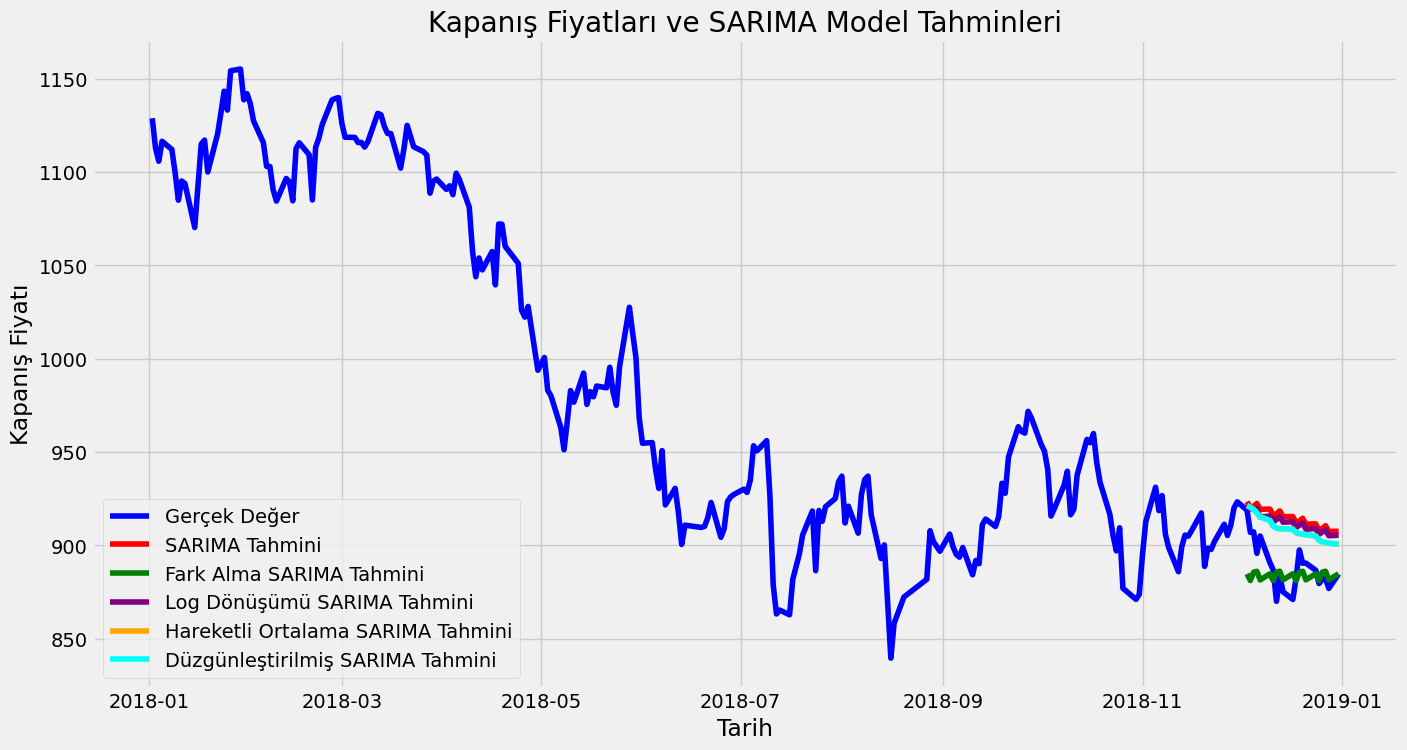

In [65]:
# SARIMA Modelleri (pmdarima ile)
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Mevsimsel parametreler (5 iş günü = haftalık)
seasonal_order = (1, 1, 1, 5)

# 1) Orijinal Close - SARIMA
order_sar = get_auto_order(train['Close'])
predictions_sarima = SARIMAX(train['Close'], order=order_sar, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False).fit(disp=False).forecast(steps=len(test))

# 2) Differencing - SARIMA
order_sar_diff = get_auto_order(train['Close_Diff'])
pred_sarima_diff = SARIMAX(train['Close_Diff'], order=order_sar_diff, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False).fit(disp=False).forecast(steps=len(test))
predictions_sarima_diff = pred_sarima_diff + test['Close'].iloc[-1]

# 3) Log dönüşümü - SARIMA
order_sar_log = get_auto_order(train['Close_Log'])
predictions_sarima_log = np.exp(SARIMAX(train['Close_Log'], order=order_sar_log, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False).fit(disp=False).forecast(steps=len(test)))

# 4) Hareketli ortalama - SARIMA
order_sar_mov = get_auto_order(train['Moving_Avg'])
predictions_sarima_mov_avg = SARIMAX(train['Moving_Avg'], order=order_sar_mov, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False).fit(disp=False).forecast(steps=len(test))

# 5) Düzgünleştirilmiş - SARIMA
order_sar_smooth = get_auto_order(smooth_series)
predictions_sarima_smooth = SARIMAX(smooth_series, order=order_sar_smooth, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False).fit(disp=False).forecast(steps=len(test))

# Grafik
plt.figure(figsize=(15,8))
plt.plot(df.index, df['Close'], label='Gerçek Değer', color='blue')
plt.plot(test.index, predictions_sarima, label='SARIMA Tahmini', color='red')
plt.plot(test.index, predictions_sarima_diff, label='Fark Alma SARIMA Tahmini', color='green')
plt.plot(test.index, predictions_sarima_log, label='Log Dönüşümü SARIMA Tahmini', color='purple')
plt.plot(test.index, predictions_sarima_mov_avg, label='Hareketli Ortalama SARIMA Tahmini', color='orange')
plt.plot(test.index, predictions_sarima_smooth, label='Düzgünleştirilmiş SARIMA Tahmini', color='cyan')

plt.title('Kapanış Fiyatları ve SARIMA Model Tahminleri')
plt.xlabel('Tarih')
plt.ylabel('Kapanış Fiyatı')
plt.legend(loc='lower left')
plt.show()

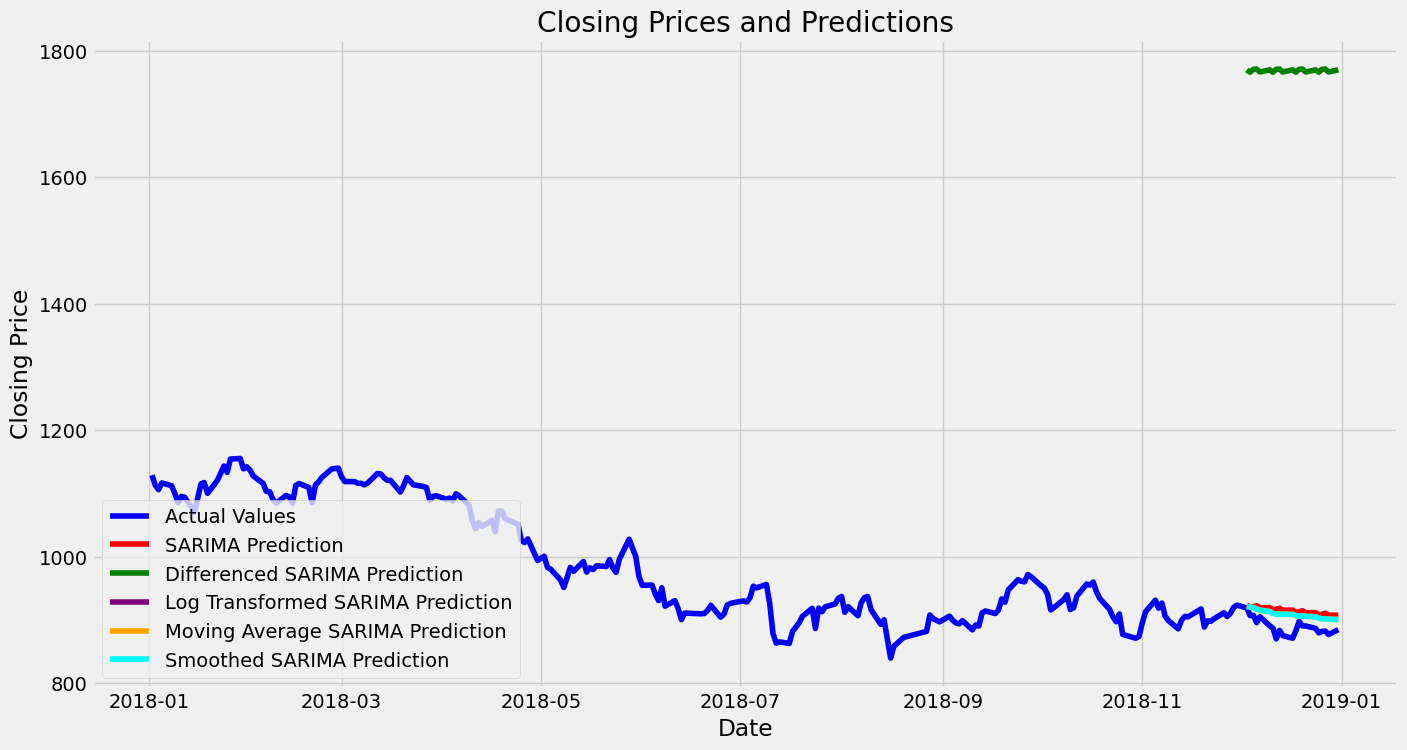

In [66]:
# SARIMA Modeli (İngilizce)
# SARIMA Modeli için Grafik Oluşturma
plt.figure(figsize=(15,8))
plt.plot(df.index, df['Close'], label='Actual Values', color='blue')
plt.plot(test.index, predictions_sarima, label='SARIMA Prediction', color='red')
plt.plot(test.index, predictions_sarima_diff.add(test['Close'].iloc[-1]), label='Differenced SARIMA Prediction', color='green')
plt.plot(test.index, np.exp(predictions_sarima_log), label='Log Transformed SARIMA Prediction', color='purple')
plt.plot(test.index, predictions_sarima_mov_avg, label='Moving Average SARIMA Prediction', color='orange')
plt.plot(test.index, predictions_sarima_smooth, label='Smoothed SARIMA Prediction', color='cyan')


# Başlık ve Etiketler
plt.title('Closing Prices and Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(loc='lower left')

# Grafik Gösterimi
plt.show()

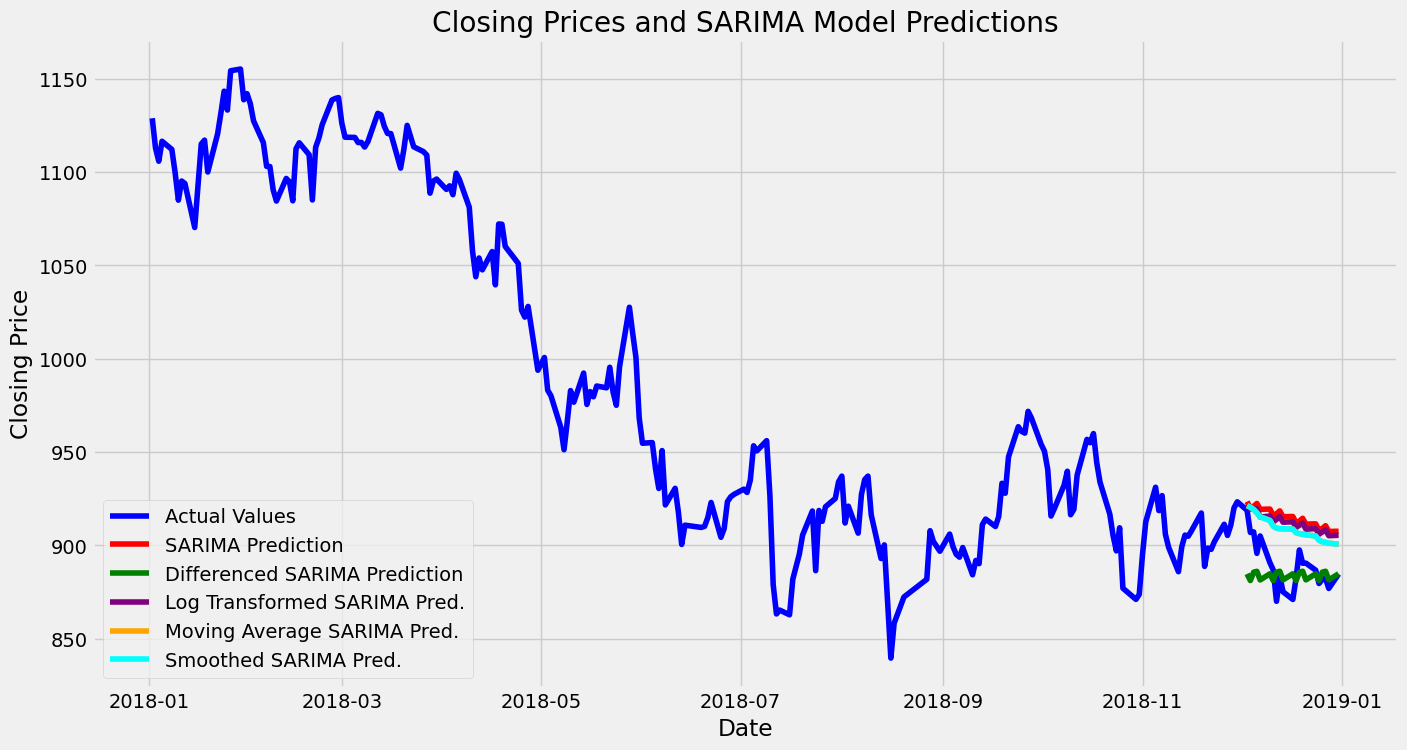

In [67]:
# SARIMA Models - English version
# Using predictions from Cell 73

plt.figure(figsize=(15, 8))
plt.plot(df.index, df["Close"], label="Actual Values", color="blue")
plt.plot(test.index, predictions_sarima, label="SARIMA Prediction", color="red")
plt.plot(test.index, predictions_sarima_diff, label="Differenced SARIMA Prediction", color="green")
plt.plot(test.index, predictions_sarima_log, label="Log Transformed SARIMA Pred.", color="purple")
plt.plot(test.index, predictions_sarima_mov_avg, label="Moving Average SARIMA Pred.", color="orange")
plt.plot(test.index, predictions_sarima_smooth, label="Smoothed SARIMA Pred.", color="cyan")

plt.title("Closing Prices and SARIMA Model Predictions")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend(loc="lower left")
plt.show()

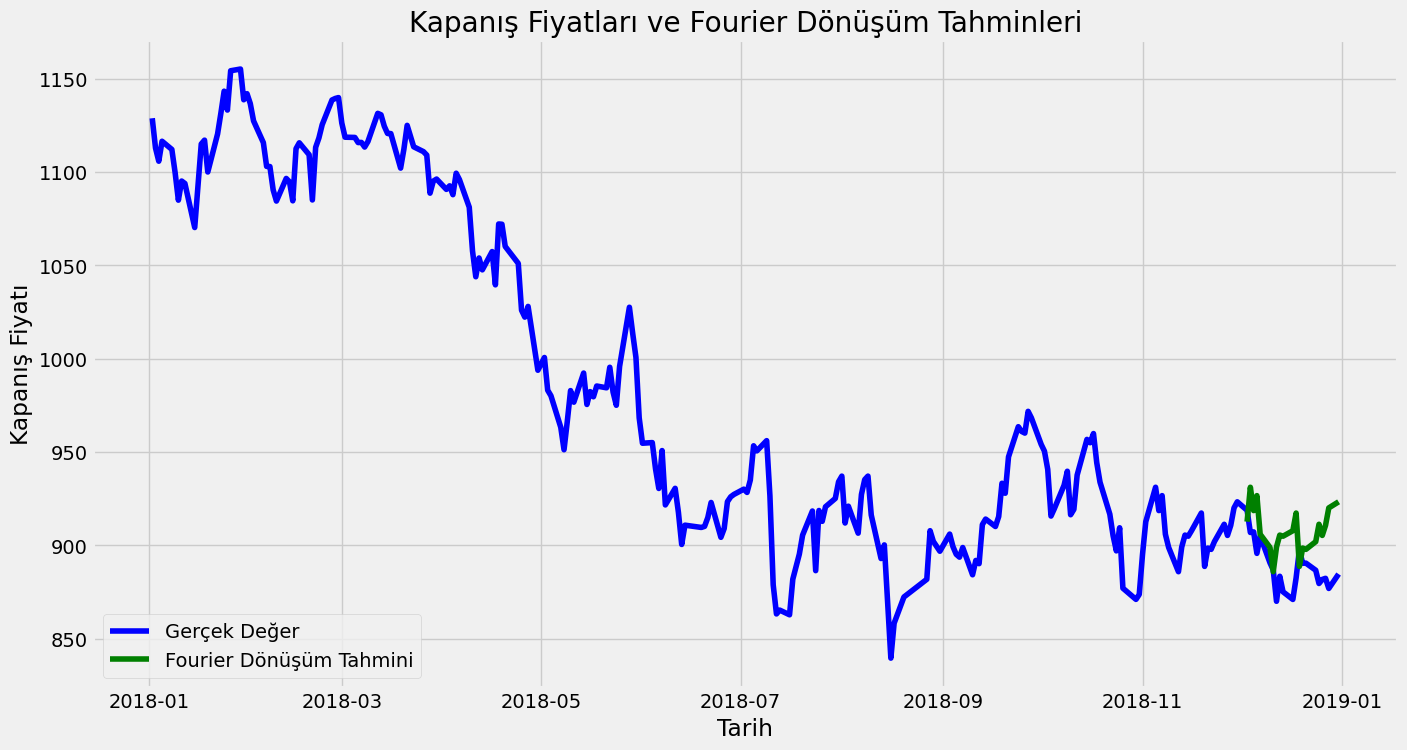

In [68]:
#Fourier Dönüşüm
fourier_transform = np.fft.fft(train['Close'])
fourier_inverse = np.fft.ifft(fourier_transform)
predictions_fourier = fourier_inverse.real[-len(test):]


# SARIMA Modeli için Grafik Oluşturma
plt.figure(figsize=(15,8))
plt.plot(df.index, df['Close'], label='Gerçek Değer', color='blue')
plt.plot(test.index, predictions_fourier, label='Fourier Dönüşüm Tahmini', color='green')


plt.title('Kapanış Fiyatları ve Fourier Dönüşüm Tahminleri')
plt.xlabel('Tarih')
plt.ylabel('Kapanış Fiyatı')
plt.legend(loc='lower left')
plt.show()

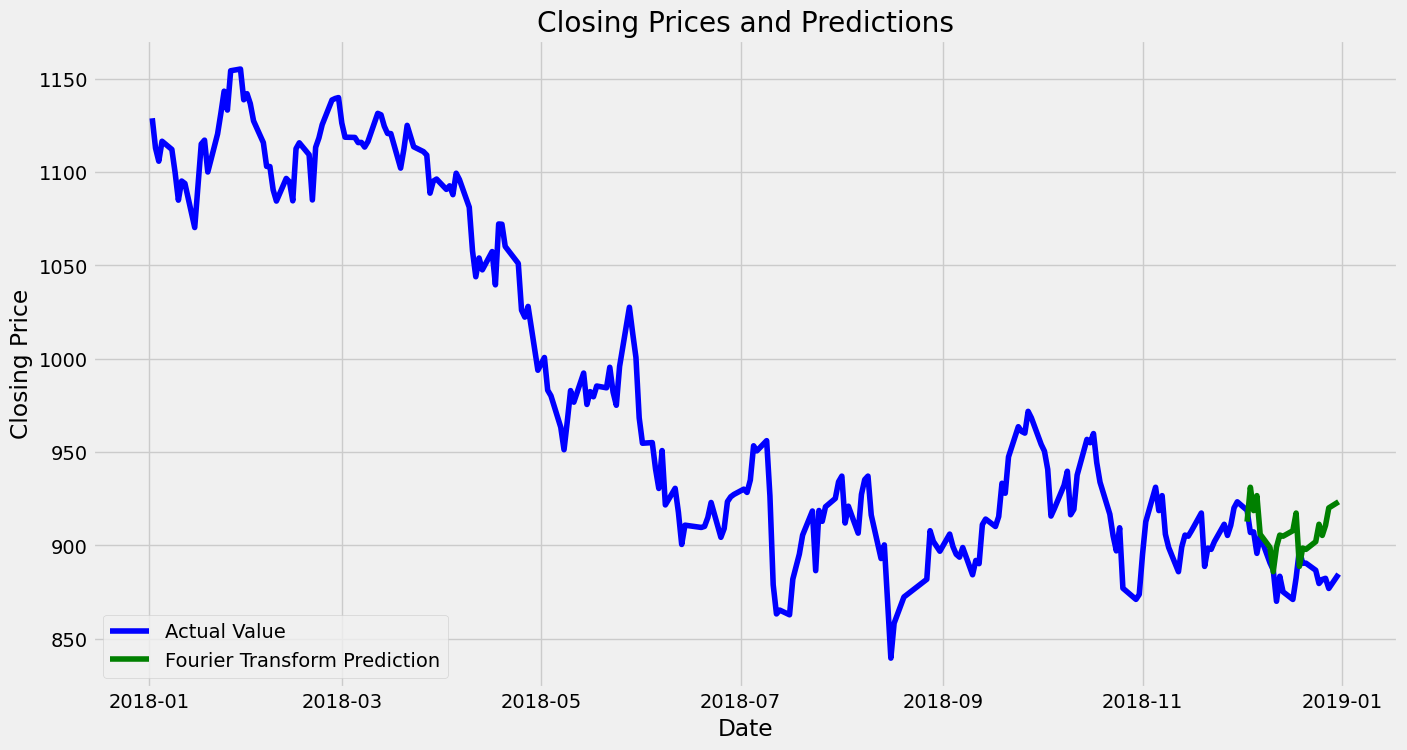

In [69]:
#Fourier Dönüşüm (İngilizce)

# SARIMA Modeli için Grafik Oluşturma
plt.figure(figsize=(15,8))
plt.plot(df.index, df['Close'], label='Actual Value', color='blue')
plt.plot(test.index, predictions_fourier, label='Fourier Transform Prediction', color='green')


# Başlık ve Etiketler
plt.title('Closing Prices and Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(loc='lower left')

# Grafik Gösterimi
plt.show()

In [70]:
test['Close']

Date
2018-12-03    918.81
2018-12-04    906.93
2018-12-05    907.25
2018-12-06    895.73
2018-12-07    905.04
2018-12-10    890.69
2018-12-11    886.86
2018-12-12    870.05
2018-12-13    883.46
2018-12-14    875.14
2018-12-17    871.04
2018-12-18    882.59
2018-12-19    897.57
2018-12-20    890.45
2018-12-21    890.49
2018-12-24    886.69
2018-12-25    879.59
2018-12-26    881.76
2018-12-27    882.36
2018-12-28    876.93
2018-12-31    884.65
Freq: D, Name: Close, dtype: float64

In [71]:
predictions_ar

2018-08-19    923.35
2018-08-20    923.35
2018-08-21    923.35
2018-08-22    923.35
2018-08-23    923.35
2018-08-24    923.35
2018-08-25    923.35
2018-08-26    923.35
2018-08-27    923.35
2018-08-28    923.35
2018-08-29    923.35
2018-08-30    923.35
2018-08-31    923.35
2018-09-01    923.35
2018-09-02    923.35
2018-09-03    923.35
2018-09-04    923.35
2018-09-05    923.35
2018-09-06    923.35
2018-09-07    923.35
2018-09-08    923.35
Freq: D, Name: predicted_mean, dtype: float64

In [72]:
# Gerçek değerler ve tahminler
y_true = test['Close'].dropna() # NaN olmayan gerçek değerler

# predictions_ar zaten test uzunluğunda, index eşleştirmesi gerek yok
# Doğrudan değerleri kullan
y_pred = predictions_ar[:len(y_true)]
y_pred

2018-08-19    923.35
2018-08-20    923.35
2018-08-21    923.35
2018-08-22    923.35
2018-08-23    923.35
2018-08-24    923.35
2018-08-25    923.35
2018-08-26    923.35
2018-08-27    923.35
2018-08-28    923.35
2018-08-29    923.35
2018-08-30    923.35
2018-08-31    923.35
2018-09-01    923.35
2018-09-02    923.35
2018-09-03    923.35
2018-09-04    923.35
2018-09-05    923.35
2018-09-06    923.35
2018-09-07    923.35
2018-09-08    923.35
Freq: D, Name: predicted_mean, dtype: float64

GÖSTERGELER

In [73]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Gerçek değerler
y_true = test['Close'].dropna() # NaN olmayan gerçek değerler

# Tahminleri pandas Series'e dönüştür (index eşleştirmesi olmadan)
# Her tahmin zaten test uzunluğunda
n = len(y_true)

predictions_ar_series = pd.Series(predictions_ar[:n].values if hasattr(predictions_ar, 'values') else predictions_ar[:n], index=y_true.index)
predictions_ar_diff_series = pd.Series(predictions_ar_diff[:n].values if hasattr(predictions_ar_diff, 'values') else predictions_ar_diff[:n], index=y_true.index)
predictions_ar_log_series = pd.Series(predictions_ar_log[:n].values if hasattr(predictions_ar_log, 'values') else predictions_ar_log[:n], index=y_true.index)
predictions_ar_mov_avg_series = pd.Series(predictions_ar_mov_avg[:n].values if hasattr(predictions_ar_mov_avg, 'values') else predictions_ar_mov_avg[:n], index=y_true.index)
predictions_ar_smooth_series = pd.Series(predictions_ar_smooth[:n].values if hasattr(predictions_ar_smooth, 'values') else predictions_ar_smooth[:n], index=y_true.index)

predictions_ma_series = pd.Series(predictions_ma[:n].values if hasattr(predictions_ma, 'values') else predictions_ma[:n], index=y_true.index)
predictions_ma_diff_series = pd.Series(predictions_ma_diff[:n].values if hasattr(predictions_ma_diff, 'values') else predictions_ma_diff[:n], index=y_true.index)
predictions_ma_log_series = pd.Series(predictions_ma_log[:n].values if hasattr(predictions_ma_log, 'values') else predictions_ma_log[:n], index=y_true.index)
predictions_ma_mov_avg_series = pd.Series(predictions_ma_mov_avg[:n].values if hasattr(predictions_ma_mov_avg, 'values') else predictions_ma_mov_avg[:n], index=y_true.index)
predictions_ma_smooth_series = pd.Series(predictions_ma_smooth[:n].values if hasattr(predictions_ma_smooth, 'values') else predictions_ma_smooth[:n], index=y_true.index)

predictions_arma_series = pd.Series(predictions_arma[:n].values if hasattr(predictions_arma, 'values') else predictions_arma[:n], index=y_true.index)
predictions_arma_diff_series = pd.Series(predictions_arma_diff[:n].values if hasattr(predictions_arma_diff, 'values') else predictions_arma_diff[:n], index=y_true.index)
predictions_arma_log_series = pd.Series(predictions_arma_log[:n].values if hasattr(predictions_arma_log, 'values') else predictions_arma_log[:n], index=y_true.index)
predictions_arma_mov_avg_series = pd.Series(predictions_arma_mov_avg[:n].values if hasattr(predictions_arma_mov_avg, 'values') else predictions_arma_mov_avg[:n], index=y_true.index)
predictions_arma_smooth_series = pd.Series(predictions_arma_smooth[:n].values if hasattr(predictions_arma_smooth, 'values') else predictions_arma_smooth[:n], index=y_true.index)

predictions_arima_series = pd.Series(predictions_arima[:n].values if hasattr(predictions_arima, 'values') else predictions_arima[:n], index=y_true.index)
predictions_arima_diff_series = pd.Series(predictions_arima_diff[:n].values if hasattr(predictions_arima_diff, 'values') else predictions_arima_diff[:n], index=y_true.index)
predictions_arima_log_series = pd.Series(predictions_arima_log[:n].values if hasattr(predictions_arima_log, 'values') else predictions_arima_log[:n], index=y_true.index)
predictions_arima_mov_avg_series = pd.Series(predictions_arima_mov_avg[:n].values if hasattr(predictions_arima_mov_avg, 'values') else predictions_arima_mov_avg[:n], index=y_true.index)
predictions_arima_smooth_series = pd.Series(predictions_arima_smooth[:n].values if hasattr(predictions_arima_smooth, 'values') else predictions_arima_smooth[:n], index=y_true.index)

predictions_sarima_series = pd.Series(predictions_sarima[:n].values if hasattr(predictions_sarima, 'values') else predictions_sarima[:n], index=y_true.index)
predictions_sarima_diff_series = pd.Series(predictions_sarima_diff[:n].values if hasattr(predictions_sarima_diff, 'values') else predictions_sarima_diff[:n], index=y_true.index)
predictions_sarima_log_series = pd.Series(predictions_sarima_log[:n].values if hasattr(predictions_sarima_log, 'values') else predictions_sarima_log[:n], index=y_true.index)
predictions_sarima_mov_avg_series = pd.Series(predictions_sarima_mov_avg[:n].values if hasattr(predictions_sarima_mov_avg, 'values') else predictions_sarima_mov_avg[:n], index=y_true.index)
predictions_sarima_smooth_series = pd.Series(predictions_sarima_smooth[:n].values if hasattr(predictions_sarima_smooth, 'values') else predictions_sarima_smooth[:n], index=y_true.index)

# Tahmin listesi
model_names = [
    "AR", "AR Fark Alma", "AR Log Dönüşümü", "AR Hareketli Ortalama", "AR Düzgünleştirilmiş",
    "MA", "MA Fark Alma", "MA Log Dönüşümü", "MA Hareketli Ortalama", "MA Düzgünleştirilmiş",
    "ARMA", "ARMA Fark Alma", "ARMA Log Dönüşümü", "ARMA Hareketli Ortalama", "ARMA Düzgünleştirilmiş",
    "ARIMA", "ARIMA Fark Alma", "ARIMA Log Dönüşümü", "ARIMA Hareketli Ortalama", "ARIMA Düzgünleştirilmiş",
    "SARIMA", "SARIMA Fark Alma", "SARIMA Log Dönüşümü", "SARIMA Hareketli Ortalama", "SARIMA Düzgünleştirilmiş"
]

models_predictions = [
    predictions_ar_series, predictions_ar_diff_series, predictions_ar_log_series, predictions_ar_mov_avg_series, predictions_ar_smooth_series,
    predictions_ma_series, predictions_ma_diff_series, predictions_ma_log_series, predictions_ma_mov_avg_series, predictions_ma_smooth_series,
    predictions_arma_series, predictions_arma_diff_series, predictions_arma_log_series, predictions_arma_mov_avg_series, predictions_arma_smooth_series,
    predictions_arima_series, predictions_arima_diff_series, predictions_arima_log_series, predictions_arima_mov_avg_series, predictions_arima_smooth_series,
    predictions_sarima_series, predictions_sarima_diff_series, predictions_sarima_log_series, predictions_sarima_mov_avg_series, predictions_sarima_smooth_series
]

print(f" {len(models_predictions)} model tahminleri hazırlandı.")

 25 model tahminleri hazırlandı.


In [74]:
# Fourier tahmini ve performans değerlendirmesi
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Fourier Dönüşümü
fourier_transform = np.fft.fft(train["Close"].values)
fourier_inverse = np.fft.ifft(fourier_transform)
pred_fourier = fourier_inverse.real

# Gerçek değerler (NaN'ler çıkarıldı)
y_true = test["Close"].dropna()
n = len(y_true)

# Fourier tahminini test seti uzunluğuna kes
pred_fourier_aligned = pred_fourier[-n:] if len(pred_fourier) >= n else np.pad(pred_fourier, (0, n - len(pred_fourier)), 'edge')[-n:]

# Tüm tahminleri sözlükte topla
pred_dict = {
    "AR": predictions_ar,
    "AR Fark Alma": predictions_ar_diff,
    "AR Log Dönüşümü": predictions_ar_log,
    "AR Hareketli Ortalama": predictions_ar_mov_avg,
    "AR Düzgünleştirilmiş": predictions_ar_smooth,
    "MA": predictions_ma,
    "MA Fark Alma": predictions_ma_diff,
    "MA Log Dönüşümü": predictions_ma_log,
    "MA Hareketli Ortalama": predictions_ma_mov_avg,
    "MA Düzgünleştirilmiş": predictions_ma_smooth,
    "ARMA": predictions_arma,
    "ARMA Fark Alma": predictions_arma_diff,
    "ARMA Log Dönüşümü": predictions_arma_log,
    "ARMA Hareketli Ortalama": predictions_arma_mov_avg,
    "ARMA Düzgünleştirilmiş": predictions_arma_smooth,
    "ARIMA": predictions_arima,
    "ARIMA Fark Alma": predictions_arima_diff,
    "ARIMA Log Dönüşümü": predictions_arima_log,
    "ARIMA Hareketli Ortalama": predictions_arima_mov_avg,
    "ARIMA Düzgünleştirilmiş": predictions_arima_smooth,
    "SARIMA": predictions_sarima,
    "SARIMA Fark Alma": predictions_sarima_diff,
    "SARIMA Log Dönüşümü": predictions_sarima_log,
    "SARIMA Hareketli Ortalama": predictions_sarima_mov_avg,
    "SARIMA Düzgünleştirilmiş": predictions_sarima_smooth,
    "Fourier Dönüşümü": pd.Series(pred_fourier_aligned, index=y_true.index)
}

def calc_metrics(y_true, y_pred, model_name):
    y_true_arr = y_true.values if hasattr(y_true, 'values') else np.array(y_true)
    y_pred_arr = y_pred.values if hasattr(y_pred, 'values') else np.array(y_pred)
    min_len = min(len(y_true_arr), len(y_pred_arr))
    y_true_arr = y_true_arr[:min_len]
    y_pred_arr = y_pred_arr[:min_len]
    mse = mean_squared_error(y_true_arr, y_pred_arr)
    mae = mean_absolute_error(y_true_arr, y_pred_arr)
    mape = mean_absolute_percentage_error(y_true_arr, y_pred_arr)
    r2 = r2_score(y_true_arr, y_pred_arr)
    rmse = np.sqrt(mse)
    relative_rmse = rmse / np.mean(y_true_arr)
    return {
        "Model": model_name,
        "RMSE": round(rmse, 4),
        "Relative_RMSE": round(relative_rmse, 4),
        "MAE": round(mae, 4),
        "MAPE": round(mape, 4),
        "R2": round(r2, 4)
    }

results = []
for model_name, predictions in pred_dict.items():
    try:
        metrics = calc_metrics(y_true, predictions, model_name)
        results.append(metrics)
    except Exception as e:
        print(f" {model_name} için hata: {e}")

sorted_performance_df = pd.DataFrame(results).sort_values(by='RMSE')
print("\n" + "="*80)
print(" TÜM MODEL SONUÇLARI (RMSE'ye göre sıralı)")
print("="*80)
print(sorted_performance_df.to_string(index=False))
print("="*80)



 TÜM MODEL SONUÇLARI (RMSE'ye göre sıralı)
                    Model     RMSE  Relative_RMSE      MAE   MAPE         R2
             AR Fark Alma  13.3543         0.0150   9.8474 0.0110    -0.1593
           ARMA Fark Alma  13.3543         0.0150   9.8474 0.0110    -0.1593
          ARIMA Fark Alma  13.3543         0.0150   9.8474 0.0110    -0.1593
         SARIMA Fark Alma  13.4260         0.0151   9.8638 0.0110    -0.1718
 SARIMA Düzgünleştirilmiş  22.2043         0.0250  20.3422 0.0230    -2.2051
SARIMA Hareketli Ortalama  22.2043         0.0250  20.3422 0.0230    -2.2051
         Fourier Dönüşümü  24.6179         0.0277  20.9771 0.0237    -2.9398
      SARIMA Log Dönüşümü  25.6341         0.0288  23.6597 0.0268    -3.2718
                   SARIMA  28.0655         0.0316  26.1433 0.0296    -4.1205
 ARIMA Hareketli Ortalama  32.7641         0.0369  30.8101 0.0348    -5.9786
     AR Düzgünleştirilmiş  32.7641         0.0369  30.8101 0.0348    -5.9786
    AR Hareketli Ortalama  32.76

## Makine Öğrenmesi Modelleri

Time Series modellerine ek olarak ML modelleri de test ediyoruz:
- Support Vector Machine (SVM)
- Random Forest
- Decision Tree
- K-Nearest Neighbors (KNN)
- Linear Regression

In [75]:
print("="*80)
print(" MACHINE LEARNING MODELLERİ")
print("="*80)

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

def create_features(data, time_step=30):
    df_feat = pd.DataFrame(index=data.index)
    for i in range(1, time_step + 1):
        df_feat[f'lag_{i}'] = data['Close'].shift(i)
    df_feat['target'] = data['Close']
    df_feat = df_feat.dropna()
    return df_feat

TIME_STEP = 30
df_ml = create_features(df, TIME_STEP)

test_size = len(test)
train_ml = df_ml.iloc[:-test_size]
test_ml = df_ml.iloc[-test_size:]

X_train_ml = train_ml.drop('target', axis=1)
y_train_ml = train_ml['target']
X_test_ml = test_ml.drop('target', axis=1)
y_test_ml = test_ml['target']

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train_ml)
X_test_scaled = scaler_X.transform(X_test_ml)
y_train_scaled = scaler_y.fit_transform(y_train_ml.values.reshape(-1, 1)).flatten()

print(f" ML Train: {X_train_scaled.shape[0]} örnek, {X_train_scaled.shape[1]} feature")
print(f" ML Test: {X_test_scaled.shape[0]} örnek")

ml_models = {
    'SVM': SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'Linear Regression': LinearRegression()
}

ml_predictions = {}
ml_metrics = {}

print("\n ML Model Eğitimi:")
print("-" * 60)

for name, model in ml_models.items():
    print(f"\n {name} eğitiliyor...")
    try:
        model.fit(X_train_scaled, y_train_scaled)
        pred_scaled = model.predict(X_test_scaled)
        pred = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()
        ml_predictions[name] = pred
        mae = mean_absolute_error(y_test_ml, pred)
        rmse = np.sqrt(mean_squared_error(y_test_ml, pred))
        r2 = r2_score(y_test_ml, pred)
        ml_metrics[name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}
        print(f" {name}: MAE={mae:.4f}, RMSE={rmse:.4f}, R²={r2:.4f}")
    except Exception as e:
        print(f" {name} hatası: {e}")

print("\n" + "="*60)
print(" Tüm ML modelleri eğitildi!")
print("="*60)


 MACHINE LEARNING MODELLERİ
 ML Train: 199 örnek, 30 feature
 ML Test: 21 örnek

 ML Model Eğitimi:
------------------------------------------------------------

 SVM eğitiliyor...
 SVM: MAE=13.4566, RMSE=16.2373, R²=-0.7139

 Random Forest eğitiliyor...
 Random Forest: MAE=12.9851, RMSE=14.7592, R²=-0.4161

 Decision Tree eğitiliyor...
 Decision Tree: MAE=18.9810, RMSE=20.8748, R²=-1.8328

 KNN eğitiliyor...
 KNN: MAE=18.0056, RMSE=20.8703, R²=-1.8316

 Linear Regression eğitiliyor...
 Linear Regression: MAE=7.5447, RMSE=9.3612, R²=0.4303

 Tüm ML modelleri eğitildi!


In [76]:
print("="*80)
print(" TÜM MODEL SONUÇLARI KARŞILAŞTIRMASI (ML + Time Series)")
print("="*80)

ml_results_list = []
for name, metrics in ml_metrics.items():
    ml_results_list.append({
        'Model': name,
        'Kategori': 'Machine Learning',
        'MAE': metrics['MAE'],
        'RMSE': metrics['RMSE'],
        'R2': metrics['R2']
    })

ml_df = pd.DataFrame(ml_results_list)

ts_results_list = []
for name, pred in pred_dict.items():
    if pred is not None:
        try:
            pred_arr = pred.values if hasattr(pred, 'values') else np.array(pred)
            pred_arr = pred_arr[:n]
            mae = mean_absolute_error(y_true[:len(pred_arr)], pred_arr)
            rmse = np.sqrt(mean_squared_error(y_true[:len(pred_arr)], pred_arr))
            r2 = r2_score(y_true[:len(pred_arr)], pred_arr)
            ts_results_list.append({
                'Model': name,
                'Kategori': 'Time Series',
                'MAE': mae,
                'RMSE': rmse,
                'R2': r2
            })
        except Exception as e:
            pass

ts_df = pd.DataFrame(ts_results_list)

all_results = pd.concat([ml_df, ts_df], ignore_index=True)
all_results = all_results.sort_values('RMSE').reset_index(drop=True)

print("\n Tüm Modeller (RMSE'ye göre sıralı):")
print("-" * 80)
print(all_results.to_string(index=False))

best = all_results.iloc[0]
print(f"\n EN İYİ MODEL: {best['Model']} ({best['Kategori']})")
print(f" RMSE: {best['RMSE']:.4f}, MAE: {best['MAE']:.4f}, R²: {best['R2']:.4f}")

print("\n KATEGORİ BAZINDA EN İYİLER:")
print("-" * 60)
for cat in ['Machine Learning', 'Time Series']:
    cat_df = all_results[all_results['Kategori'] == cat]
    if len(cat_df) > 0:
        best_cat = cat_df.iloc[0]
        print(f" {cat}: {best_cat['Model']} (RMSE={best_cat['RMSE']:.4f}, R²={best_cat['R2']:.4f})")

print("\n" + "="*80)


 TÜM MODEL SONUÇLARI KARŞILAŞTIRMASI (ML + Time Series)

 Tüm Modeller (RMSE'ye göre sıralı):
--------------------------------------------------------------------------------
                    Model         Kategori        MAE       RMSE           R2
        Linear Regression Machine Learning   7.544728   9.361170     0.430321
             AR Fark Alma      Time Series   9.847416  13.354335    -0.159349
          ARIMA Fark Alma      Time Series   9.847416  13.354335    -0.159349
           ARMA Fark Alma      Time Series   9.847416  13.354335    -0.159349
         SARIMA Fark Alma      Time Series   9.863822  13.426007    -0.171827
            Random Forest Machine Learning  12.985067  14.759225    -0.416109
                      SVM Machine Learning  13.456604  16.237266    -0.713939
                      KNN Machine Learning  18.005619  20.870309    -1.831571
            Decision Tree Machine Learning  18.980952  20.874782    -1.832784
SARIMA Hareketli Ortalama      Time Series  2

In [77]:
# Veriyi Excel dosyasına kaydedin
#excel_file_name = f'/content/drive/MyDrive/Thesis & Articles/Deneyler/ZamanSerileriAnalizi_BorsaSonuclari_{start_date}_{end_date}_tahminEdilecekGunSayisi_{tahminEdilecekGunSayisi}.xlsx'
#sorted_performance_df.to_excel(excel_file_name, index=False)

In [78]:
from scipy import stats
import numpy as np
import pandas as pd

# Gerçek test değerleri - SADECE TEST VERİSİ
y_true = test['Close'].dropna().values

# Model tahminlerini listele
predictions_list = models_predictions
model_names_list = model_names

# Metriği hesaplayan yardımcı fonksiyon
def calculate_metrics(y_true, y_pred):
    # Uzunlukları eşitle
    y_pred_arr = y_pred.values if hasattr(y_pred, 'values') else np.array(y_pred)
    min_len = min(len(y_true), len(y_pred_arr))
    y_t = y_true[:min_len]
    y_p = y_pred_arr[:min_len]

    mae = mean_absolute_error(y_t, y_p)
    rmse = np.sqrt(mean_squared_error(y_t, y_p))
    r2 = r2_score(y_t, y_p)
    return mae, rmse, r2

# Bootstrap güven aralığı
def bootstrap_ci(data, num_samples=1000, ci=95):
    data = np.array(data).flatten()
    sample_means = [np.mean(np.random.choice(data, size=len(data), replace=True)) for _ in range(num_samples)]
    lower = np.percentile(sample_means, (100 - ci) / 2)
    upper = np.percentile(sample_means, 100 - (100 - ci) / 2)
    return (lower, upper)

# İki modeli karşılaştıran fonksiyon
def compare_models(index1, index2):
    y_pred1 = predictions_list[index1]
    y_pred2 = predictions_list[index2]

    name1 = model_names_list[index1]
    name2 = model_names_list[index2]

    # Numpy array'e çevir
    y_pred1_arr = y_pred1.values if hasattr(y_pred1, 'values') else np.array(y_pred1)
    y_pred2_arr = y_pred2.values if hasattr(y_pred2, 'values') else np.array(y_pred2)

    # Uzunlukları eşitle
    min_len = min(len(y_true), len(y_pred1_arr), len(y_pred2_arr))
    y_t = y_true[:min_len]
    y_p1 = y_pred1_arr[:min_len]
    y_p2 = y_pred2_arr[:min_len]

    m1 = calculate_metrics(y_t, y_p1)
    m2 = calculate_metrics(y_t, y_p2)

    errors1 = np.abs(y_t - y_p1)
    errors2 = np.abs(y_t - y_p2)

    t_stat, p_ttest = stats.ttest_rel(errors1, errors2)
    w_stat, p_wilcoxon = stats.wilcoxon(errors1, errors2)

    ci1 = bootstrap_ci(errors1)
    ci2 = bootstrap_ci(errors2)

    results = pd.DataFrame({
    "Metric": ["MAE", "RMSE", "R2", "Paired t-test p-value", "Wilcoxon p-value", "95% CI (mean error)"],
    name1: [m1[0], m1[1], m1[2], p_ttest, p_wilcoxon, ci1],
    name2: [m2[0], m2[1], m2[2], "", "", ci2]
    })

    return results

# Örnek karşılaştırma: ARIMA vs SARIMA
results_df = compare_models(15, 20)
print(results_df.to_string(index=False))

               Metric                                   ARIMA                                  SARIMA
                  MAE                               34.584286                               26.143291
                 RMSE                               36.740972                               28.065531
                   R2                               -7.775481                               -4.120544
Paired t-test p-value                                     0.0                                        
     Wilcoxon p-value                                0.000002                                        
  95% CI (mean error) (29.405166666666716, 39.46985714285714) (22.03479732154371, 30.954253380812876)


In [79]:
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np, pandas as pd

y_true = test["Close"].dropna()
n = len(y_true)

models_predictions = []
model_names = list(pred_dict.keys())

for name, pred in pred_dict.items():
    if hasattr(pred, 'values'):
        arr = pred.values
    else:
        arr = np.array(pred)
    arr = arr[:n] if len(arr) >= n else np.pad(arr, (0, n - len(arr)), 'edge')[:n]
    models_predictions.append(arr)

def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

def bootstrap_ci(data, num_samples=1000, ci=95):
    data = np.array(data).flatten()
    if len(data) == 0:
        return (0, 0)
    sample_means = [np.mean(np.random.choice(data, size=len(data), replace=True)) for _ in range(num_samples)]
    return (np.percentile(sample_means, (100-ci)/2), np.percentile(sample_means, 100-(100-ci)/2))


In [80]:
# =============================================================================
# TÜM PERİYOTLAR İÇİN SONUÇLAR (1 gün, 10 gün, 21 gün)
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import os

# Sonuç dizini
SONUC_DIZINI = '/content/drive/MyDrive/Colab Notebooks/Sonuclar/2_TimeSeries_ML'
os.makedirs(SONUC_DIZINI, exist_ok=True)

# Notebook bilgileri
NOTEBOOK_ADI = "2_TimeSeries_ML"
VERI_TIPI = "az_veri"

print("=" * 80)
print(f" {NOTEBOOK_ADI} - TÜM PERİYOTLAR İÇİN TEST")
print(f" Veri Tipi: {VERI_TIPI.upper()}")
print("=" * 80)

# Tüm sonuçları toplayacak liste
tum_sonuclar = []

# Gerçek değerler (tüm test verisi)
y_true_full = test['Close'].values

# Her periyot için test
for periyot_adi, gun_sayisi in TAHMIN_PERIYOTLARI.items():
    print(f"\n{'='*60}")
    print(f" {periyot_adi} ({gun_sayisi} iş günü) test ediliyor...")
    print('='*60)

    # Bu periyot için gerçek değerler (son N gün)
    y_true = y_true_full[-gun_sayisi:] if len(y_true_full) >= gun_sayisi else y_true_full
    n = len(y_true)

    # ----- TIME SERIES MODELLERİ -----
    if 'pred_dict' in dir() and pred_dict:
        for model_name, pred in pred_dict.items():
            if pred is not None:
                try:
                    pred_arr = pred.values if hasattr(pred, 'values') else np.array(pred)
                    # Son N günü al
                    pred_n = pred_arr[-gun_sayisi:] if len(pred_arr) >= gun_sayisi else pred_arr

                    # Boyut eşitle
                    min_len = min(len(y_true), len(pred_n))
                    y_t = y_true[:min_len]
                    p_t = pred_n[:min_len]

                    # Metrikler
                    rmse = np.sqrt(mean_squared_error(y_t, p_t))
                    mae = mean_absolute_error(y_t, p_t)
                    r2 = r2_score(y_t, p_t)
                    mape = mean_absolute_percentage_error(y_t, p_t) * 100

                    tum_sonuclar.append({
                        'Model': model_name,
                        'Kategori': 'Time Series',
                        'Veri_Tipi': VERI_TIPI,
                        'Periyot': periyot_adi,
                        'Periyot_Gun': gun_sayisi,
                        'RMSE': round(rmse, 4),
                        'MAE': round(mae, 4),
                        'R2': round(r2, 4),
                        'MAPE': round(mape, 2)
                    })
                    print(f"  ✓ {model_name}: RMSE={rmse:.4f}, R²={r2:.4f}")
                except Exception as e:
                    print(f"  ✗ {model_name}: {e}")

    # ----- MACHINE LEARNING MODELLERİ -----
    if 'ml_models' in dir() and ml_models:
        for model_name, model in ml_models.items():
            try:
                # Son N gün için tahmin
                X_test_n = X_test[-gun_sayisi:] if len(X_test) >= gun_sayisi else X_test
                y_test_n = y_test[-gun_sayisi:] if len(y_test) >= gun_sayisi else y_test

                pred_n = model.predict(X_test_n)

                # Metrikler
                rmse = np.sqrt(mean_squared_error(y_test_n, pred_n))
                mae = mean_absolute_error(y_test_n, pred_n)
                r2 = r2_score(y_test_n, pred_n)
                mape = mean_absolute_percentage_error(y_test_n, pred_n) * 100

                tum_sonuclar.append({
                    'Model': model_name,
                    'Kategori': 'Machine Learning',
                    'Veri_Tipi': VERI_TIPI,
                    'Periyot': periyot_adi,
                    'Periyot_Gun': gun_sayisi,
                    'RMSE': round(rmse, 4),
                    'MAE': round(mae, 4),
                    'R2': round(r2, 4),
                    'MAPE': round(mape, 2)
                })
                print(f"  ✓ {model_name}: RMSE={rmse:.4f}, R²={r2:.4f}")
            except Exception as e:
                print(f"  ✗ {model_name}: {e}")

    # ml_metrics varsa (alternatif)
    elif 'ml_metrics' in dir() and ml_metrics:
        for model_name, metrics in ml_metrics.items():
            # Not: ml_metrics zaten hesaplanmış, periyoda göre yeniden hesaplayamıyoruz
            # Bu durumda sadece mevcut metrikleri kullan
            if periyot_adi == AKTIF_PERIYOT:  # Sadece aktif periyot için
                tum_sonuclar.append({
                    'Model': model_name,
                    'Kategori': 'Machine Learning',
                    'Veri_Tipi': VERI_TIPI,
                    'Periyot': periyot_adi,
                    'Periyot_Gun': gun_sayisi,
                    'RMSE': round(metrics.get('RMSE', np.nan), 4),
                    'MAE': round(metrics.get('MAE', np.nan), 4),
                    'R2': round(metrics.get('R2', np.nan), 4),
                    'MAPE': round(metrics.get('MAPE', 0) * 100, 2)
                })

# DataFrame oluştur
sonuc_df = pd.DataFrame(tum_sonuclar)
print(f"\n✅ Toplam {len(sonuc_df)} test sonucu toplandı")


 2_TimeSeries_ML - TÜM PERİYOTLAR İÇİN TEST
 Veri Tipi: AZ_VERI

 1_gun (1 iş günü) test ediliyor...
  ✓ AR: RMSE=38.7000, R²=nan
  ✓ AR Fark Alma: RMSE=0.8352, R²=nan
  ✓ AR Log Dönüşümü: RMSE=38.7000, R²=nan
  ✓ AR Hareketli Ortalama: RMSE=34.2181, R²=nan
  ✓ AR Düzgünleştirilmiş: RMSE=34.2181, R²=nan
  ✓ MA: RMSE=104.2242, R²=nan
  ✓ MA Fark Alma: RMSE=885.4852, R²=nan
  ✓ MA Log Dönüşümü: RMSE=877.7576, R²=nan
  ✓ MA Hareketli Ortalama: RMSE=105.1791, R²=nan
  ✓ MA Düzgünleştirilmiş: RMSE=105.1791, R²=nan
  ✓ ARMA: RMSE=104.2242, R²=nan
  ✓ ARMA Fark Alma: RMSE=0.8352, R²=nan
  ✓ ARMA Log Dönüşümü: RMSE=100.1565, R²=nan
  ✓ ARMA Hareketli Ortalama: RMSE=61.6190, R²=nan
  ✓ ARMA Düzgünleştirilmiş: RMSE=61.6190, R²=nan
  ✓ ARIMA: RMSE=38.7000, R²=nan
  ✓ ARIMA Fark Alma: RMSE=0.8352, R²=nan
  ✓ ARIMA Log Dönüşümü: RMSE=38.7000, R²=nan
  ✓ ARIMA Hareketli Ortalama: RMSE=34.2181, R²=nan
  ✓ ARIMA Düzgünleştirilmiş: RMSE=34.2181, R²=nan
  ✓ SARIMA: RMSE=22.9333, R²=nan
  ✓ SARIMA Fark A

In [81]:
# =============================================================================
# SONUÇ TABLOLARI (Model × Periyot)
# =============================================================================

if len(sonuc_df) > 0:
    print("\n" + "=" * 80)
    print(" RMSE TABLOSU (Model × Periyot)")
    print("=" * 80)
    pivot_rmse = sonuc_df.pivot_table(index='Model', columns='Periyot', values='RMSE', aggfunc='first')
    if '1_gun' in pivot_rmse.columns:
        pivot_rmse = pivot_rmse[['1_gun', '10_gun', '21_gun']]
    print(pivot_rmse.round(4).to_string())

    print("\n" + "=" * 80)
    print(" R² TABLOSU (Model × Periyot)")
    print("=" * 80)
    pivot_r2 = sonuc_df.pivot_table(index='Model', columns='Periyot', values='R2', aggfunc='first')
    if '1_gun' in pivot_r2.columns:
        pivot_r2 = pivot_r2[['1_gun', '10_gun', '21_gun']]
    print(pivot_r2.round(4).to_string())

    print("\n" + "=" * 80)
    print(" MAE TABLOSU (Model × Periyot)")
    print("=" * 80)
    pivot_mae = sonuc_df.pivot_table(index='Model', columns='Periyot', values='MAE', aggfunc='first')
    if '1_gun' in pivot_mae.columns:
        pivot_mae = pivot_mae[['1_gun', '10_gun', '21_gun']]
    print(pivot_mae.round(4).to_string())

    # En iyi modeller
    print("\n" + "=" * 80)
    print(" EN İYİ MODELLER (RMSE bazında)")
    print("=" * 80)
    for periyot in ['1_gun', '10_gun', '21_gun']:
        subset = sonuc_df[sonuc_df['Periyot'] == periyot]
        if len(subset) > 0:
            best = subset.loc[subset['RMSE'].idxmin()]
            print(f"  {periyot:8} → {best['Model']:20} (RMSE: {best['RMSE']:.4f}, R²: {best['R2']:.4f})")
else:
    print("\n⚠️ Sonuç bulunamadı!")



 RMSE TABLOSU (Model × Periyot)
Periyot                       1_gun    10_gun    21_gun
Model                                                  
AR                          38.7000   38.4831   36.7410
AR Düzgünleştirilmiş        34.2181   34.1328   32.7641
AR Fark Alma                 0.8352    5.9987   13.3543
AR Hareketli Ortalama       34.2181   34.1328   32.7641
AR Log Dönüşümü             38.7000   38.4831   36.7410
ARIMA                       38.7000   38.4831   36.7410
ARIMA Düzgünleştirilmiş     34.2181   34.1328   32.7641
ARIMA Fark Alma              0.8352    5.9987   13.3543
ARIMA Hareketli Ortalama    34.2181   34.1328   32.7641
ARIMA Log Dönüşümü          38.7000   38.4831   36.7410
ARMA                       104.2242  103.7290  100.8739
ARMA Düzgünleştirilmiş      61.6190   57.8352   51.3776
ARMA Fark Alma               0.8352    5.9987   13.3543
ARMA Hareketli Ortalama     61.6190   57.8352   51.3776
ARMA Log Dönüşümü          100.1565   99.6680   96.8383
Fourier Dönüşüm

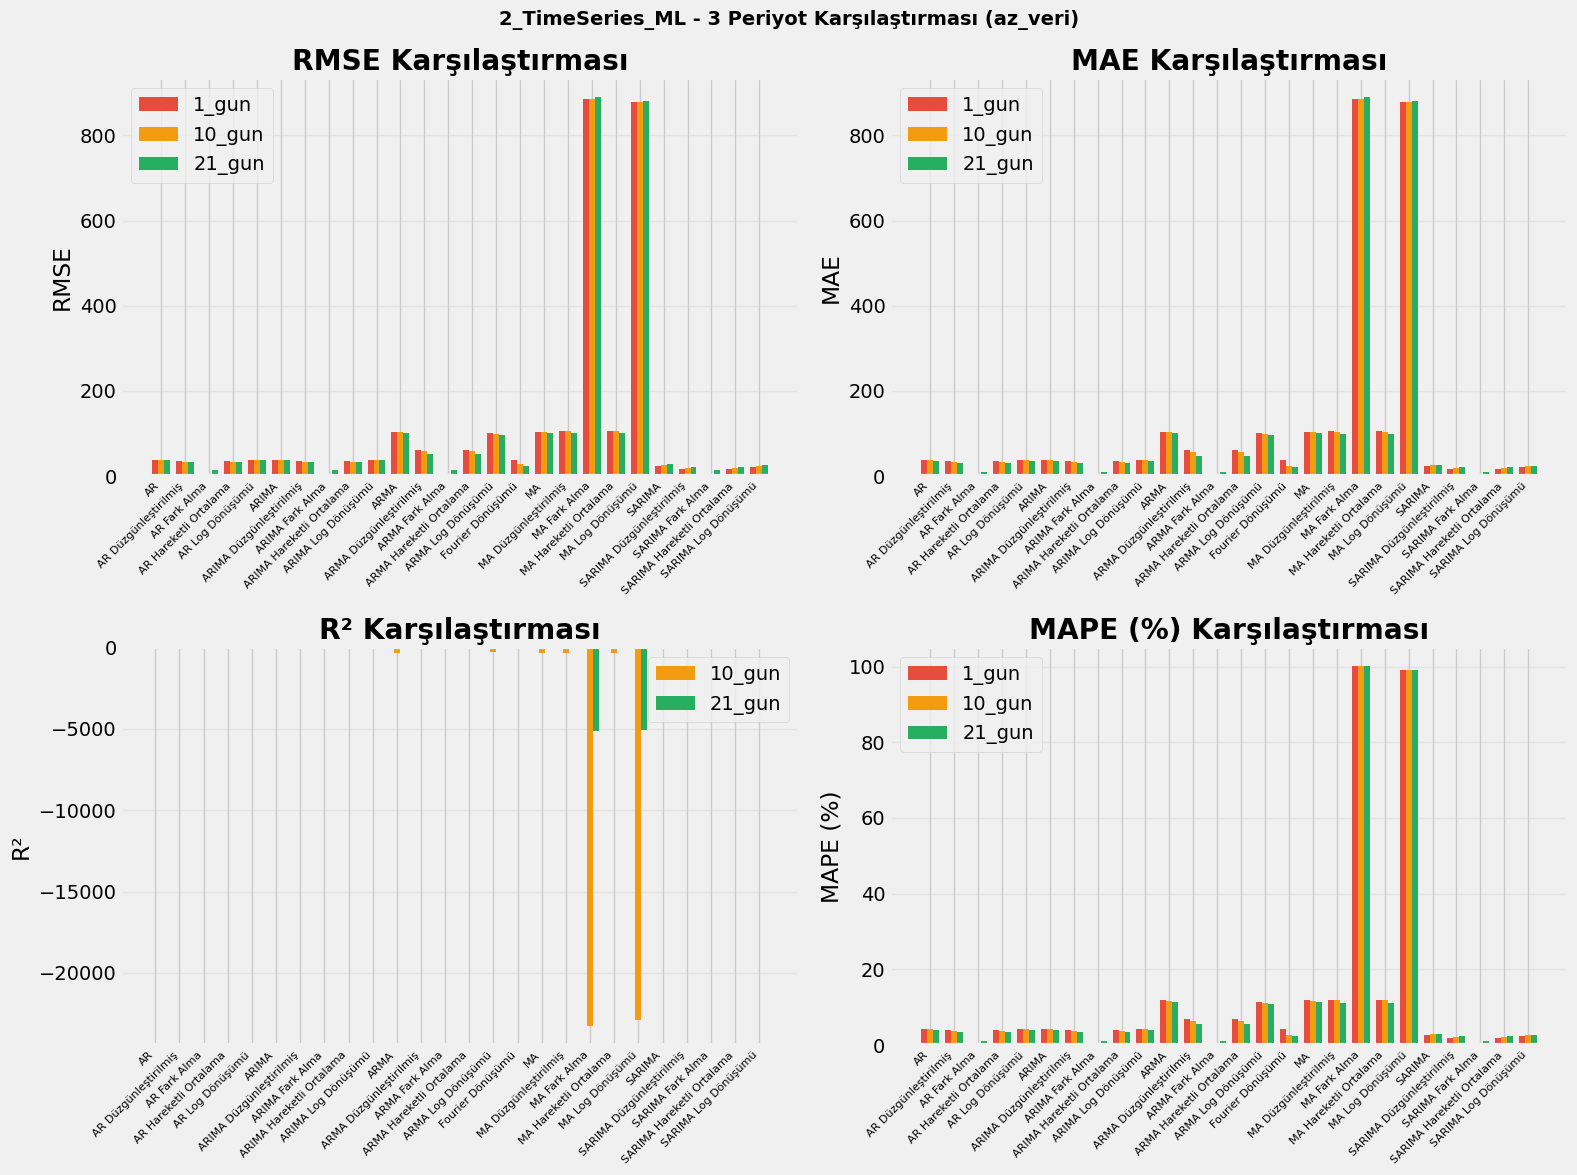


📈 Grafik kaydedildi: /content/drive/MyDrive/Colab Notebooks/Sonuclar/2_TimeSeries_ML/2_TimeSeries_ML_3periyot_karsilastirma.png


In [82]:
# =============================================================================
# KARŞILAŞTIRMA GRAFİKLERİ (3 Periyot - Kırmızı/Turuncu/Yeşil)
# =============================================================================

if len(sonuc_df) > 0 and '1_gun' in sonuc_df['Periyot'].values:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'{NOTEBOOK_ADI} - 3 Periyot Karşılaştırması ({VERI_TIPI})',
                 fontsize=14, fontweight='bold')

    # Pivot tablolar
    pivot_rmse = sonuc_df.pivot_table(index='Model', columns='Periyot', values='RMSE', aggfunc='first')
    pivot_mae = sonuc_df.pivot_table(index='Model', columns='Periyot', values='MAE', aggfunc='first')
    pivot_r2 = sonuc_df.pivot_table(index='Model', columns='Periyot', values='R2', aggfunc='first')
    pivot_mape = sonuc_df.pivot_table(index='Model', columns='Periyot', values='MAPE', aggfunc='first')

    models = pivot_rmse.index.tolist()
    x = np.arange(len(models))
    width = 0.25
    colors = ['#e74c3c', '#f39c12', '#27ae60']  # 1_gun=kırmızı, 10_gun=turuncu, 21_gun=yeşil
    periyotlar = ['1_gun', '10_gun', '21_gun']

    # 1. RMSE
    ax1 = axes[0, 0]
    for i, periyot in enumerate(periyotlar):
        if periyot in pivot_rmse.columns:
            values = pivot_rmse[periyot].values
            ax1.bar(x + i*width, values, width, label=periyot, color=colors[i])
    ax1.set_title('RMSE Karşılaştırması', fontweight='bold')
    ax1.set_ylabel('RMSE')
    ax1.set_xticks(x + width)
    ax1.set_xticklabels(models, rotation=45, ha='right', fontsize=8)
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)

    # 2. MAE
    ax2 = axes[0, 1]
    for i, periyot in enumerate(periyotlar):
        if periyot in pivot_mae.columns:
            values = pivot_mae[periyot].values
            ax2.bar(x + i*width, values, width, label=periyot, color=colors[i])
    ax2.set_title('MAE Karşılaştırması', fontweight='bold')
    ax2.set_ylabel('MAE')
    ax2.set_xticks(x + width)
    ax2.set_xticklabels(models, rotation=45, ha='right', fontsize=8)
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)

    # 3. R²
    ax3 = axes[1, 0]
    for i, periyot in enumerate(periyotlar):
        if periyot in pivot_r2.columns:
            values = pivot_r2[periyot].values
            ax3.bar(x + i*width, values, width, label=periyot, color=colors[i])
    ax3.set_title('R² Karşılaştırması', fontweight='bold')
    ax3.set_ylabel('R²')
    ax3.set_xticks(x + width)
    ax3.set_xticklabels(models, rotation=45, ha='right', fontsize=8)
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)

    # 4. MAPE
    ax4 = axes[1, 1]
    for i, periyot in enumerate(periyotlar):
        if periyot in pivot_mape.columns:
            values = pivot_mape[periyot].values
            ax4.bar(x + i*width, values, width, label=periyot, color=colors[i])
    ax4.set_title('MAPE (%) Karşılaştırması', fontweight='bold')
    ax4.set_ylabel('MAPE (%)')
    ax4.set_xticks(x + width)
    ax4.set_xticklabels(models, rotation=45, ha='right', fontsize=8)
    ax4.legend()
    ax4.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"{SONUC_DIZINI}/{NOTEBOOK_ADI}_3periyot_karsilastirma.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\n📈 Grafik kaydedildi: {SONUC_DIZINI}/{NOTEBOOK_ADI}_3periyot_karsilastirma.png")
else:
    print("\n⚠️ 3 periyot verisi bulunamadı!")


In [83]:
# =============================================================================
# EXCEL'E KAYDET
# =============================================================================

if len(sonuc_df) > 0:
    excel_dosya = f"{SONUC_DIZINI}/{NOTEBOOK_ADI}_tum_sonuclar.xlsx"

    with pd.ExcelWriter(excel_dosya, engine='openpyxl') as writer:
        # Ham veriler
        sonuc_df.to_excel(writer, sheet_name='Tum_Sonuclar', index=False)

        # Pivot tablolar
        if 'pivot_rmse' in dir():
            pivot_rmse.to_excel(writer, sheet_name='RMSE')
        if 'pivot_mae' in dir():
            pivot_mae.to_excel(writer, sheet_name='MAE')
        if 'pivot_r2' in dir():
            pivot_r2.to_excel(writer, sheet_name='R2')
        if 'pivot_mape' in dir():
            pivot_mape.to_excel(writer, sheet_name='MAPE')

    print(f"\n✅ Tüm sonuçlar kaydedildi: {excel_dosya}")

    # Özet
    print("\n" + "=" * 80)
    print(f" ÖZET - {NOTEBOOK_ADI}")
    print("=" * 80)
    print(f" Veri Tipi: {VERI_TIPI}")
    print(f" Kategori: Time Series & Machine Learning")
    print(f" Test Edilen Periyotlar: 1_gun, 10_gun, 21_gun")
    print(f" Toplam Test Sonucu: {len(sonuc_df)}")
    print("=" * 80)



✅ Tüm sonuçlar kaydedildi: /content/drive/MyDrive/Colab Notebooks/Sonuclar/2_TimeSeries_ML/2_TimeSeries_ML_tum_sonuclar.xlsx

 ÖZET - 2_TimeSeries_ML
 Veri Tipi: az_veri
 Kategori: Time Series & Machine Learning
 Test Edilen Periyotlar: 1_gun, 10_gun, 21_gun
 Toplam Test Sonucu: 78
